<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/home/cosenza/thesis/Polyphemus


In [2]:
!git branch

  main
* sparse


Libraries installation

In [20]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [21]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [22]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [3]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [4]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_PAD_IND = 2
MAX_DUR = 511 # equivalent to 16 bars (with RESOLUTION=32)

RESOLUTION = 32
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION) == 0 \
                            else length + (RESOLUTION-(length%(RESOLUTION)))


        tracks_tensors = []
        tracks_activations = []

        dur_bin_length = int(np.ceil(np.log2(MAX_DUR)))

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time

                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue

                track_tensor[t, notes_counter[t], 0] = note.pitch
                track_tensor[t, notes_counter[t], 1] = note.duration
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS

            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)

            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION+1, RESOLUTION):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION]

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
                

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_EOS)
            seq_tensor[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples




# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [5]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [6]:
dataset_dir = 'data/lmd_matched'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [7]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=10)

Starting preprocessing


  0%|          | 0/10 [00:00<?, ?it/s]

Current path: data/lmd_matched

Current path: data/lmd_matched/A

Current path: data/lmd_matched/A/A

Current path: data/lmd_matched/A/A/A

Current path: data/lmd_matched/A/A/A/TRAAAGR128F425B14B

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/1d9d16a9da90c090809c153754823c2b.mid
Processing combination 1 of 7
Processing combination 2 of 7
Processing combination 3 of 7
Processing combination 4 of 7
Processing combination 5 of 7
Processing combination 6 of 7
Processing combination 7 of 7
File preprocessing finished. Saved samples: 3031

Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 1
Total number of saved samples: 3031

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/5dd29e99ed7bd3cc0c5177a6e9de22ea.mid
Processing combination 1 of 5
Processing combination 2 of 5
Processing combination 3 of 5
Processing combination 4 of 5
Processing combination 5 of 5
File preprocessing finished. Saved samples: 2105

Total number of 

/home/cosenza/anaconda3/envs/thesis/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Processing combination 1 of 2
Processing combination 2 of 2
File preprocessing finished. Saved samples: 1107

Total number of seen files: 3
Number of unique files: 3
Total number of non filtered songs: 3
Total number of saved samples: 6243

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/b97c529ab9ef783a849b896816001748.mid
Processing combination 1 of 4
Processing combination 2 of 4
Processing combination 3 of 4
Processing combination 4 of 4
File preprocessing finished. Saved samples: 1812

Total number of seen files: 4
Number of unique files: 4
Total number of non filtered songs: 4
Total number of saved samples: 8055

Current path: data/lmd_matched/A/A/A/TRAAAZF12903CCCF6B

Preprocessing file data/lmd_matched/A/A/A/TRAAAZF12903CCCF6B/c24989559d170135b9c6546d1d2df20b.mid
Processing combination 1 of 16
Processing combination 2 of 16
Processing combination 3 of 16
Processing combination 4 of 16
Processing combination 5 of 16
Processing combination 6 of 16
Processing combinat

In [8]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [9]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [10]:
data["seq_tensor"][0, 0]

array([[128,   0],
       [129,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0]], dtype=int16)

# Model

In [11]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot[np.arange(0, onehot.shape[0]), pitches.reshape(-1)] = 1.
        onehot = onehot.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to binary (pitch)
        durs = seq_tensor[:, :, :, 1]
        bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]

        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot[:, :, :, :], bin_durs),
                             axis=-1)
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [141]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
        self.p = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=140, d_transf=256, nhead_transf=4, 
                 num_layers_transf=6, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(x_graph.x, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=140, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=6, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, 140)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


Trainer

In [142]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criterions with ignored padding
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce = nn.CrossEntropyLoss(ignore_index=130) #
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph, src_mask = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                src_mask = src_mask.to(self.device)
                tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph, src_mask, tgt_mask)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss and filter silences
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130).unsqueeze(-1)
                
        # Compute the losses
        acts_loss = self.bce_unreduced(acts_rec.view(-1), x_acts.view(-1).float())
        weights = torch.zeros(acts_loss.size()).to(device)
        weights[x_acts.view(-1) == 1] = 0.9
        weights[x_acts.view(-1) == 0] = 0.1
        acts_loss = 50 * torch.mean(weights*acts_loss)
        
        pitches_loss = self.ce(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        dur_loss = self.bce_unreduced(seq_rec[..., 131:], 
                       x_seq[..., 131:])
        dur_loss = mask * dur_loss
        dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss + dur_loss + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            'dur': dur_loss.item(),
            'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        dur_acc = self._dur_accuracy(seq_rec, x_seq)
        acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            'dur': dur_acc.item(),
            'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        print(torch.all(pitches_rec == 129))
        #print(pitches_rec)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        print(torch.all(dur_rec == 0))
        #print(dur_rec)
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(torch.logical_and(preds_pitches, 
                                           preds_dur)) / torch.sum(mask)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        print(torch.all(acts_rec == 0))
        #print(acts_rec)
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        


Training

In [143]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [144]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

31001

In [145]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#decive = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 0


In [146]:
!rm models/vae

rm: cannot remove ‘models/vae’: No such file or directory


In [147]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [148]:
print("Creating the model and moving it to the specified device...")

vae = VAE(dropout=0).to(device)
print_params(vae)
print()

init_lr = 5e-6
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='vae3',
    lr_scheduler=scheduler,
    save_every=100, 
    device=device
)
trainer.train(loader, epochs=100)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   35840    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

  0%|          | 0/969 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.27
Losses:
{'tot': 16.510719299316406, 'pitches': 5.232733726501465, 'dur': 6.491693019866943, 'acts': 4.786293029785156, 'rec': 16.510719299316406, 'kld': 2134.07421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.002109704539179802, 'dur': 0.0, 'acts': 0.517578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.56
Losses:
{'tot': 16.33938980102539, 'pitches': 5.141145706176758, 'dur': 6.335789203643799, 'acts': 4.862455368041992, 'rec': 16.33938980102539, 'kld': 2122.09814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0, 'dur': 0.0, 'acts': 0.511474609375}

---------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 17/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:03.81
Losses:
{'tot': 13.949211120605469, 'pitches': 4.907541275024414, 'dur': 4.522677898406982, 'acts': 4.518990993499756, 'rec': 13.949211120605469, 'kld': 2037.16162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0, 'dur': 0.28604650497436523, 'acts': 0.534912109375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 18/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:04.01
Losses:
{'tot': 13.894445419311523, 'pitches': 4.843016624450684, 'dur': 4.480411052703857, 'acts': 4.571017742156982, 'rec': 13.894445419311523, 'kld': 2027.352783203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.01154734380543232, 'dur': 0.2401847541332245, 'acts': 0.527587890625}

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 33/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:06.93
Losses:
{'tot': 12.787425994873047, 'pitches': 4.575488090515137, 'dur': 3.569493293762207, 'acts': 4.642444133758545, 'rec': 12.787425994873047, 'kld': 1942.6142578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.08080808073282242, 'pitches': 0.17373737692832947, 'dur': 0.3010101020336151, 'acts': 0.556640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 34/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:07.13
Losses:
{'tot': 12.66387939453125, 'pitches': 4.603507995605469, 'dur': 3.654183864593506, 'acts': 4.406187534332275, 'rec': 12.66387939453125, 'kld': 1935.437255859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.061403509229421616, 'pitches': 0.15570175647735596, 'dur': 0

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 49/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:09.97
Losses:
{'tot': 11.905452728271484, 'pitches': 4.342675685882568, 'dur': 3.2711925506591797, 'acts': 4.2915849685668945, 'rec': 11.905452728271484, 'kld': 1925.3780517578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.22270742058753967, 'pitches': 0.3253275156021118, 'dur': 0.32969433069229126, 'acts': 0.581787109375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 50/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:10.17
Losses:
{'tot': 11.947723388671875, 'pitches': 4.302428722381592, 'dur': 3.1639323234558105, 'acts': 4.481362819671631, 'rec': 11.947723388671875, 'kld': 1933.2928466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.23978686332702637, 'pitches': 0.32326820492744446

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 65/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:13.42
Losses:
{'tot': 11.466673851013184, 'pitches': 4.197995185852051, 'dur': 3.0532279014587402, 'acts': 4.215450763702393, 'rec': 11.466673851013184, 'kld': 1998.715576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.22745901346206665, 'pitches': 0.3237704932689667, 'dur': 0.3196721374988556, 'acts': 0.60009765625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 66/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:13.61
Losses:
{'tot': 11.366486549377441, 'pitches': 4.127058029174805, 'dur': 3.169144630432129, 'acts': 4.070283889770508, 'rec': 11.366486549377441, 'kld': 2007.7275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.1458333283662796, 'pitches': 0.3194444477558136, 'dur': 0.

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 82/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:16.66
Losses:
{'tot': 11.210434913635254, 'pitches': 4.039634704589844, 'dur': 2.975724220275879, 'acts': 4.195075988769531, 'rec': 11.210434913635254, 'kld': 2118.983154296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.21821631491184235, 'pitches': 0.3149905204772949, 'dur': 0.3149905204772949, 'acts': 0.633544921875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 83/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:16.85
Losses:
{'tot': 10.865662574768066, 'pitches': 3.9375860691070557, 'dur': 2.8783090114593506, 'acts': 4.04976749420166, 'rec': 10.865662574768066, 'kld': 2130.9736328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.14806866645812988, 'pitches': 0.3412017226219177, 'dur': 

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 98/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:19.77
Losses:
{'tot': 11.026216506958008, 'pitches': 3.9061226844787598, 'dur': 2.9670569896698, 'acts': 4.1530375480651855, 'rec': 11.026216506958008, 'kld': 2259.025146484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3036750555038452, 'pitches': 0.3462282419204712, 'dur': 0.3636363744735718, 'acts': 0.64697265625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 99/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:19.99
Losses:
{'tot': 10.764838218688965, 'pitches': 3.8731319904327393, 'dur': 2.9399991035461426, 'acts': 3.951706647872925, 'rec': 10.764838218688965, 'kld': 2266.28173828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2618556618690491, 'pitches': 0.34020617604255676, 'dur': 

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 114/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:23.40
Losses:
{'tot': 10.631156921386719, 'pitches': 3.9002294540405273, 'dur': 2.856464147567749, 'acts': 3.874462842941284, 'rec': 10.631156921386719, 'kld': 2381.2705078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.24131274223327637, 'pitches': 0.3204633295536041, 'dur': 0.30694979429244995, 'acts': 0.67041015625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 115/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:23.58
Losses:
{'tot': 10.652860641479492, 'pitches': 3.915074110031128, 'dur': 2.866579294204712, 'acts': 3.8712072372436523, 'rec': 10.652860641479492, 'kld': 2398.264892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2869378924369812, 'pitches': 0.3211991488933563, 'dur'

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 131/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:26.58
Losses:
{'tot': 10.340330123901367, 'pitches': 3.8446571826934814, 'dur': 2.6976208686828613, 'acts': 3.798051595687866, 'rec': 10.340330123901367, 'kld': 2520.404052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2678227424621582, 'pitches': 0.32947975397109985, 'dur': 0.36994218826293945, 'acts': 0.697509765625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 132/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:26.79
Losses:
{'tot': 10.285961151123047, 'pitches': 3.9123852252960205, 'dur': 2.7639334201812744, 'acts': 3.609642744064331, 'rec': 10.285961151123047, 'kld': 2519.666748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2530612349510193, 'pitches': 0.29795917868614197,

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 147/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:29.69
Losses:
{'tot': 10.278013229370117, 'pitches': 3.8900606632232666, 'dur': 2.758082628250122, 'acts': 3.6298699378967285, 'rec': 10.278013229370117, 'kld': 2652.05078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2427983582019806, 'pitches': 0.30658435821533203, 'dur': 0.33539095520973206, 'acts': 0.70361328125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 148/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:29.90
Losses:
{'tot': 10.211461067199707, 'pitches': 3.7086546421051025, 'dur': 2.857267379760742, 'acts': 3.6455392837524414, 'rec': 10.211461067199707, 'kld': 2664.374755859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2595744729042053, 'pitches': 0.3446808457374573, 'dur': 0.34893617033958435, 'acts':

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 164/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:32.98
Losses:
{'tot': 10.01445198059082, 'pitches': 3.7842490673065186, 'dur': 2.5887255668640137, 'acts': 3.641477108001709, 'rec': 10.01445198059082, 'kld': 2785.079833984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27620968222618103, 'pitches': 0.3245967626571655, 'dur': 0.3608871102333069, 'acts': 0.721435546875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 165/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:33.16
Losses:
{'tot': 10.184574127197266, 'pitches': 3.7768523693084717, 'dur': 2.6919379234313965, 'acts': 3.7157838344573975, 'rec': 10.184574127197266, 'kld': 2788.97509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2914485037326813, 'pitches': 0.3263525366783142, 'du

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 181/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:36.37
Losses:
{'tot': 10.122146606445312, 'pitches': 3.695159912109375, 'dur': 2.744141101837158, 'acts': 3.6828458309173584, 'rec': 10.122146606445312, 'kld': 2896.431884765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2976190447807312, 'pitches': 0.3531745970249176, 'dur': 0.3849206268787384, 'acts': 0.7421875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 182/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:36.56
Losses:
{'tot': 10.19597339630127, 'pitches': 3.747903823852539, 'dur': 2.7675583362579346, 'acts': 3.680511474609375, 'rec': 10.19597339630127, 'kld': 2902.4130859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2601155936717987, 'pitches': 0.32947975397109985, 'dur': 0.346

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 198/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:39.62
Losses:
{'tot': 9.769354820251465, 'pitches': 3.751847982406616, 'dur': 2.6396143436431885, 'acts': 3.3778927326202393, 'rec': 9.769354820251465, 'kld': 2998.197509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2748267948627472, 'pitches': 0.3279445767402649, 'dur': 0.37644341588020325, 'acts': 0.737548828125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 199/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:39.82
Losses:
{'tot': 10.150052070617676, 'pitches': 3.729020118713379, 'dur': 2.7698347568511963, 'acts': 3.6511971950531006, 'rec': 10.150052070617676, 'kld': 3010.235595703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2715231776237488, 'pitches': 0.34657835960388184, 'd

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 214/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:43.84
Losses:
{'tot': 9.933095932006836, 'pitches': 3.7436463832855225, 'dur': 2.751734495162964, 'acts': 3.4377150535583496, 'rec': 9.933095932006836, 'kld': 3086.250244140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2641128897666931, 'pitches': 0.3245967626571655, 'dur': 0.35080644488334656, 'acts': 0.7578125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 215/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:44.04
Losses:
{'tot': 9.914952278137207, 'pitches': 3.7287917137145996, 'dur': 2.669381856918335, 'acts': 3.5167787075042725, 'rec': 9.914952278137207, 'kld': 3093.296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2666666805744171, 'pitches': 0.3232323229312897, 'dur': 0.34747475385665894, 'acts': 0.75415039

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 230/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:47.08
Losses:
{'tot': 9.822916984558105, 'pitches': 3.7334139347076416, 'dur': 2.7607038021087646, 'acts': 3.3287994861602783, 'rec': 9.822916984558105, 'kld': 3180.40087890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2735229730606079, 'pitches': 0.31947484612464905, 'dur': 0.3741794228553772, 'acts': 0.763916015625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 231/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:47.28
Losses:
{'tot': 9.826597213745117, 'pitches': 3.7306480407714844, 'dur': 2.766061544418335, 'acts': 3.3298869132995605, 'rec': 9.826597213745117, 'kld': 3189.23974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.25757575035095215, 'pitches': 0.3246753215789795, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 246/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:50.25
Losses:
{'tot': 9.951191902160645, 'pitches': 3.599234104156494, 'dur': 2.7766659259796143, 'acts': 3.575291395187378, 'rec': 9.951191902160645, 'kld': 3274.16162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3052631616592407, 'pitches': 0.351578950881958, 'dur': 0.38736841082572937, 'acts': 0.7705078125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 247/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:50.45
Losses:
{'tot': 9.800634384155273, 'pitches': 3.7167482376098633, 'dur': 2.684474229812622, 'acts': 3.3994123935699463, 'rec': 9.800634384155273, 'kld': 3271.786865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.272549033164978, 'pitches': 0.31568628549575806, 'dur': 0.34117648005485535, 'acts': 0.77

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 262/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:53.46
Losses:
{'tot': 9.547670364379883, 'pitches': 3.824817419052124, 'dur': 2.5848257541656494, 'acts': 3.1380274295806885, 'rec': 9.547670364379883, 'kld': 3338.908203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2254098355770111, 'pitches': 0.2889344394207001, 'dur': 0.3606557250022888, 'acts': 0.787353515625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 263/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:53.66
Losses:
{'tot': 9.575441360473633, 'pitches': 3.698730945587158, 'dur': 2.510776996612549, 'acts': 3.365933418273926, 'rec': 9.575441360473633, 'kld': 3361.79248046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2851782441139221, 'pitches': 0.3339587152004242, 'dur': 0.409

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 278/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:56.48
Losses:
{'tot': 9.62868881225586, 'pitches': 3.7648446559906006, 'dur': 2.7014405727386475, 'acts': 3.1624033451080322, 'rec': 9.62868881225586, 'kld': 3423.0322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2384105920791626, 'pitches': 0.3024282455444336, 'dur': 0.366445928812027, 'acts': 0.797119140625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 279/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:56.69
Losses:
{'tot': 9.569112777709961, 'pitches': 3.7244203090667725, 'dur': 2.6892757415771484, 'acts': 3.15541672706604, 'rec': 9.569112777709961, 'kld': 3429.851318359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.24568966031074524, 'pitches': 0.3017241358757019, 'dur': 0.3

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 294/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:59.66
Losses:
{'tot': 9.316658973693848, 'pitches': 3.7657859325408936, 'dur': 2.4514143466949463, 'acts': 3.099458932876587, 'rec': 9.316658973693848, 'kld': 3494.532470703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29629629850387573, 'pitches': 0.3006536066532135, 'dur': 0.379084974527359, 'acts': 0.799072265625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 295/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:59.88
Losses:
{'tot': 9.435550689697266, 'pitches': 3.589897394180298, 'dur': 2.5724565982818604, 'acts': 3.273196220397949, 'rec': 9.435550689697266, 'kld': 3511.057861328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2842535674571991, 'pitches': 0.35173824429512024, 'dur':

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 310/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:03.65
Losses:
{'tot': 9.404254913330078, 'pitches': 3.722494602203369, 'dur': 2.627384662628174, 'acts': 3.0543761253356934, 'rec': 9.404254913330078, 'kld': 3575.04052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.23010753095149994, 'pitches': 0.301075279712677, 'dur': 0.3591397702693939, 'acts': 0.807861328125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 311/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:03.86
Losses:
{'tot': 9.518880844116211, 'pitches': 3.6481082439422607, 'dur': 2.71794056892395, 'acts': 3.152832508087158, 'rec': 9.518880844116211, 'kld': 3587.191162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.274678111076355, 'pitches': 0.33261802792549133, 'dur': 0.3

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 326/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:07.00
Losses:
{'tot': 9.36640739440918, 'pitches': 3.625030994415283, 'dur': 2.5523035526275635, 'acts': 3.189072847366333, 'rec': 9.36640739440918, 'kld': 3662.6552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2723880708217621, 'pitches': 0.33582088351249695, 'dur': 0.4197761118412018, 'acts': 0.8173828125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 327/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:07.19
Losses:
{'tot': 9.480692863464355, 'pitches': 3.6621904373168945, 'dur': 2.6893022060394287, 'acts': 3.1292002201080322, 'rec': 9.480692863464355, 'kld': 3661.107177734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.25690022110939026, 'pitches': 0.31847134232521057, 'dur': 0.

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 343/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:10.30
Losses:
{'tot': 9.247526168823242, 'pitches': 3.4887313842773438, 'dur': 2.5663444995880127, 'acts': 3.1924500465393066, 'rec': 9.247526168823242, 'kld': 3756.951416015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3325842618942261, 'pitches': 0.3617977499961853, 'dur': 0.4674157202243805, 'acts': 0.818115234375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 344/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:10.49
Losses:
{'tot': 9.374260902404785, 'pitches': 3.661442756652832, 'dur': 2.5410921573638916, 'acts': 3.1717262268066406, 'rec': 9.374260902404785, 'kld': 3749.630126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.291262149810791, 'pitches': 0.3184466063976288, 'dur':

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 360/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:13.55
Losses:
{'tot': 9.35731315612793, 'pitches': 3.646117687225342, 'dur': 2.6149988174438477, 'acts': 3.096196413040161, 'rec': 9.35731315612793, 'kld': 3820.73876953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27346938848495483, 'pitches': 0.3244898021221161, 'dur': 0.4000000059604645, 'acts': 0.820068359375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 361/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:13.74
Losses:
{'tot': 9.252779006958008, 'pitches': 3.6553943157196045, 'dur': 2.4889891147613525, 'acts': 3.1083950996398926, 'rec': 9.252779006958008, 'kld': 3815.55859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.25493717193603516, 'pitches': 0.3070017993450165, 'dur': 0.39

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 377/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:16.76
Losses:
{'tot': 9.436418533325195, 'pitches': 3.5899388790130615, 'dur': 2.6487274169921875, 'acts': 3.197751998901367, 'rec': 9.436418533325195, 'kld': 3896.88037109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27016884088516235, 'pitches': 0.3339587152004242, 'dur': 0.4277673661708832, 'acts': 0.83251953125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 378/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:16.95
Losses:
{'tot': 9.09428596496582, 'pitches': 3.5847795009613037, 'dur': 2.6044697761535645, 'acts': 2.9050371646881104, 'rec': 9.09428596496582, 'kld': 3895.2451171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.25910064578056335, 'pitches': 0.3233404755592346, 'dur': 0.

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 393/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:19.90
Losses:
{'tot': 9.156200408935547, 'pitches': 3.5980587005615234, 'dur': 2.5576581954956055, 'acts': 3.000483751296997, 'rec': 9.156200408935547, 'kld': 3957.3115234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2989247441291809, 'pitches': 0.32473117113113403, 'dur': 0.4215053617954254, 'acts': 0.83984375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 394/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:20.10
Losses:
{'tot': 9.291191101074219, 'pitches': 3.5768024921417236, 'dur': 2.523282051086426, 'acts': 3.1911067962646484, 'rec': 9.291191101074219, 'kld': 3968.6298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2875695824623108, 'pitches': 0.34137290716171265, 'dur': 0.443

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 409/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:23.84
Losses:
{'tot': 9.392911911010742, 'pitches': 3.49983549118042, 'dur': 2.6413214206695557, 'acts': 3.2517545223236084, 'rec': 9.392911911010742, 'kld': 4017.854736328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32083332538604736, 'pitches': 0.35208332538604736, 'dur': 0.46666666865348816, 'acts': 0.832275390625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 410/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:24.06
Losses:
{'tot': 9.268404960632324, 'pitches': 3.6070966720581055, 'dur': 2.770890951156616, 'acts': 2.8904170989990234, 'rec': 9.268404960632324, 'kld': 4015.960693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2659846544265747, 'pitches': 0.3120204508304596, 'dur

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 426/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:27.23
Losses:
{'tot': 9.12125301361084, 'pitches': 3.4721436500549316, 'dur': 2.566779851913452, 'acts': 3.0823299884796143, 'rec': 9.12125301361084, 'kld': 4097.8232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2871485948562622, 'pitches': 0.34337350726127625, 'dur': 0.4538152515888214, 'acts': 0.8408203125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 427/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:27.45
Losses:
{'tot': 9.017210960388184, 'pitches': 3.606736421585083, 'dur': 2.5231566429138184, 'acts': 2.887317657470703, 'rec': 9.017210960388184, 'kld': 4095.916015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2854030430316925, 'pitches': 0.3159041404724121, 'dur': 0.448801

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 442/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:30.62
Losses:
{'tot': 8.908980369567871, 'pitches': 3.526815414428711, 'dur': 2.4075429439544678, 'acts': 2.9746220111846924, 'rec': 8.908980369567871, 'kld': 4147.0302734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2836134433746338, 'pitches': 0.33193278312683105, 'dur': 0.43487393856048584, 'acts': 0.850341796875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 443/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:30.81
Losses:
{'tot': 9.001924514770508, 'pitches': 3.51794695854187, 'dur': 2.5449798107147217, 'acts': 2.938997983932495, 'rec': 9.001924514770508, 'kld': 4153.14208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28118813037872314, 'pitches': 0.3326732814311981, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 458/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:33.84
Losses:
{'tot': 8.792839050292969, 'pitches': 3.483767509460449, 'dur': 2.4489104747772217, 'acts': 2.8601608276367188, 'rec': 8.792839050292969, 'kld': 4223.5712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30645161867141724, 'pitches': 0.33870968222618103, 'dur': 0.44930875301361084, 'acts': 0.85693359375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 459/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:34.08
Losses:
{'tot': 9.139482498168945, 'pitches': 3.522608518600464, 'dur': 2.6379969120025635, 'acts': 2.978877305984497, 'rec': 9.139482498168945, 'kld': 4227.6005859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2911111116409302, 'pitches': 0.3311111032962799, 'dur': 0.42888888716697693, 'acts': 0.8

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 474/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:37.09
Losses:
{'tot': 8.97632884979248, 'pitches': 3.6071970462799072, 'dur': 2.5774941444396973, 'acts': 2.791637659072876, 'rec': 8.97632884979248, 'kld': 4285.986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2857142984867096, 'pitches': 0.30519479513168335, 'dur': 0.3961038887500763, 'acts': 0.863525390625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 475/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:37.27
Losses:
{'tot': 9.10180377960205, 'pitches': 3.582853317260742, 'dur': 2.463700771331787, 'acts': 3.0552499294281006, 'rec': 9.10180377960205, 'kld': 4291.3505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27677100896835327, 'pitches': 0.311367392539978, 'dur': 0.403624

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 491/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:40.27
Losses:
{'tot': 8.933304786682129, 'pitches': 3.5680198669433594, 'dur': 2.5844266414642334, 'acts': 2.780857801437378, 'rec': 8.933304786682129, 'kld': 4360.57958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30320149660110474, 'pitches': 0.31450092792510986, 'dur': 0.43879473209381104, 'acts': 0.868896484375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 492/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:40.48
Losses:
{'tot': 9.048417091369629, 'pitches': 3.5247509479522705, 'dur': 2.6155266761779785, 'acts': 2.90813946723938, 'rec': 9.048417091369629, 'kld': 4364.72998046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.299785852432251, 'pitches': 0.3254818022251129, 'dur': 

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 507/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:44.11
Losses:
{'tot': 8.919795989990234, 'pitches': 3.5517280101776123, 'dur': 2.461451292037964, 'acts': 2.9066162109375, 'rec': 8.919795989990234, 'kld': 4416.22265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30841121077537537, 'pitches': 0.3177570104598999, 'dur': 0.4392523467540741, 'acts': 0.864013671875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 508/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:44.29
Losses:
{'tot': 8.844237327575684, 'pitches': 3.6400368213653564, 'dur': 2.4401180744171143, 'acts': 2.764082431793213, 'rec': 8.844237327575684, 'kld': 4417.62841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.279296875, 'pitches': 0.296875, 'dur': 0.408203125, 'acts': 0.

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 523/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:47.11
Losses:
{'tot': 8.69312858581543, 'pitches': 3.3918442726135254, 'dur': 2.449798822402954, 'acts': 2.8514857292175293, 'rec': 8.69312858581543, 'kld': 4497.58837890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.350649356842041, 'pitches': 0.35281383991241455, 'dur': 0.4978354871273041, 'acts': 0.864990234375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 524/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:47.31
Losses:
{'tot': 8.784860610961914, 'pitches': 3.4801297187805176, 'dur': 2.4933948516845703, 'acts': 2.811336040496826, 'rec': 8.784860610961914, 'kld': 4494.03662109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3265306055545807, 'pitches': 0.33469387888908386, 'dur': 0.

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 540/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:50.44
Losses:
{'tot': 8.91922378540039, 'pitches': 3.480010986328125, 'dur': 2.636396646499634, 'acts': 2.8028159141540527, 'rec': 8.91922378540039, 'kld': 4556.5185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3288973271846771, 'pitches': 0.3288973271846771, 'dur': 0.45057034492492676, 'acts': 0.875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 541/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:50.65
Losses:
{'tot': 8.75936508178711, 'pitches': 3.4228947162628174, 'dur': 2.5349388122558594, 'acts': 2.8015317916870117, 'rec': 8.75936508178711, 'kld': 4565.1162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3273942172527313, 'pitches': 0.3429844081401825, 'dur': 0.4654788374900

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 556/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:53.56
Losses:
{'tot': 8.937835693359375, 'pitches': 3.4341776371002197, 'dur': 2.593712329864502, 'acts': 2.9099457263946533, 'rec': 8.937835693359375, 'kld': 4620.3603515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3214990198612213, 'pitches': 0.33136093616485596, 'dur': 0.4299802780151367, 'acts': 0.87548828125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 557/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:53.75
Losses:
{'tot': 8.878711700439453, 'pitches': 3.5959978103637695, 'dur': 2.651369571685791, 'acts': 2.631344795227051, 'rec': 8.878711700439453, 'kld': 4620.744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2965235114097595, 'pitches': 0.2985685169696808, 'dur': 0.41

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 572/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:56.57
Losses:
{'tot': 8.977468490600586, 'pitches': 3.427086114883423, 'dur': 2.674774646759033, 'acts': 2.8756072521209717, 'rec': 8.977468490600586, 'kld': 4683.58349609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33870968222618103, 'pitches': 0.3407258093357086, 'dur': 0.4556451737880707, 'acts': 0.876708984375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 573/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:56.76
Losses:
{'tot': 8.835732460021973, 'pitches': 3.5125234127044678, 'dur': 2.568094253540039, 'acts': 2.7551145553588867, 'rec': 8.835732460021973, 'kld': 4683.794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3007968068122864, 'pitches': 0.31673306226730347, 'dur': 0

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 588/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:59.67
Losses:
{'tot': 8.545866012573242, 'pitches': 3.4766366481781006, 'dur': 2.4036471843719482, 'acts': 2.6655826568603516, 'rec': 8.545866012573242, 'kld': 4743.4248046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32022473216056824, 'pitches': 0.3258427083492279, 'dur': 0.4569288492202759, 'acts': 0.879638671875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 589/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:59.88
Losses:
{'tot': 8.655961990356445, 'pitches': 3.415513038635254, 'dur': 2.3880903720855713, 'acts': 2.85235857963562, 'rec': 8.655961990356445, 'kld': 4753.6708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34224599599838257, 'pitches': 0.3440285325050354, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 605/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:03.77
Losses:
{'tot': 8.652222633361816, 'pitches': 3.484081268310547, 'dur': 2.5071613788604736, 'acts': 2.660979986190796, 'rec': 8.652222633361816, 'kld': 4801.8212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3216630220413208, 'pitches': 0.3260393738746643, 'dur': 0.4398249387741089, 'acts': 0.8896484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 606/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:03.98
Losses:
{'tot': 8.677780151367188, 'pitches': 3.446200370788574, 'dur': 2.4713799953460693, 'acts': 2.7601990699768066, 'rec': 8.677780151367188, 'kld': 4812.111328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.324701189994812, 'pitches': 0.3286852538585663, 'dur': 0.4521

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 621/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:06.88
Losses:
{'tot': 8.698307991027832, 'pitches': 3.4880552291870117, 'dur': 2.4879777431488037, 'acts': 2.7222745418548584, 'rec': 8.698307991027832, 'kld': 4855.23828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3219696879386902, 'pitches': 0.3219696879386902, 'dur': 0.4375, 'acts': 0.884521484375}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 622/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:07.08
Losses:
{'tot': 8.416677474975586, 'pitches': 3.3534719944000244, 'dur': 2.364199638366699, 'acts': 2.6990063190460205, 'rec': 8.416677474975586, 'kld': 4875.43505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34567901492118835, 'pitches': 0.3477366268634796, 'dur': 0.46707817912

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 638/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:10.19
Losses:
{'tot': 8.564315795898438, 'pitches': 3.414468765258789, 'dur': 2.4083986282348633, 'acts': 2.7414488792419434, 'rec': 8.564315795898438, 'kld': 4924.958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32987552881240845, 'pitches': 0.32987552881240845, 'dur': 0.4605809152126312, 'acts': 0.878173828125}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 639/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:10.38
Losses:
{'tot': 8.568103790283203, 'pitches': 3.400019884109497, 'dur': 2.4673752784729004, 'acts': 2.7007081508636475, 'rec': 8.568103790283203, 'kld': 4937.16552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33898305892944336, 'pitches': 0.33898305892944336, 'dur':

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 654/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:13.29
Losses:
{'tot': 8.571279525756836, 'pitches': 3.5011870861053467, 'dur': 2.407276153564453, 'acts': 2.662815570831299, 'rec': 8.571279525756836, 'kld': 4980.6201171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3030303120613098, 'pitches': 0.31385281682014465, 'dur': 0.4437229335308075, 'acts': 0.8916015625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 655/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:13.49
Losses:
{'tot': 8.599006652832031, 'pitches': 3.464334011077881, 'dur': 2.3252012729644775, 'acts': 2.8094708919525146, 'rec': 8.599006652832031, 'kld': 4993.5302734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31578946113586426, 'pitches': 0.3251879811286926, 'dur': 0.

tensor(False, device='cuda:0')
Training on batch 669/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:16.21
Losses:
{'tot': 8.527580261230469, 'pitches': 3.434404134750366, 'dur': 2.445986032485962, 'acts': 2.6471900939941406, 'rec': 8.527580261230469, 'kld': 5042.22314453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32101166248321533, 'pitches': 0.32295718789100647, 'dur': 0.43579766154289246, 'acts': 0.8935546875}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 670/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:16.40
Losses:
{'tot': 8.524238586425781, 'pitches': 3.355618715286255, 'dur': 2.402749538421631, 'acts': 2.7658700942993164, 'rec': 8.524238586425781, 'kld': 5042.869140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.335206001996994, 'pitches': 0.33895131945610046, 'dur': 0.46441948413848877, 'acts': 0.8955078125}

---------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 685/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:19.37
Losses:
{'tot': 8.671309471130371, 'pitches': 3.382544994354248, 'dur': 2.6147210597991943, 'acts': 2.674043893814087, 'rec': 8.671309471130371, 'kld': 5089.0947265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3222222328186035, 'pitches': 0.324444442987442, 'dur': 0.42444443702697754, 'acts': 0.885498046875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 686/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:19.57
Losses:
{'tot': 8.725835800170898, 'pitches': 3.455998182296753, 'dur': 2.575404644012451, 'acts': 2.6944334506988525, 'rec': 8.725835800170898, 'kld': 5095.265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31611570715904236, 'pitches': 0.32438015937805176, 'dur': 0.446

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 701/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:23.23
Losses:
{'tot': 8.482901573181152, 'pitches': 3.47052264213562, 'dur': 2.58970046043396, 'acts': 2.4226784706115723, 'rec': 8.482901573181152, 'kld': 5147.57763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30576440691947937, 'pitches': 0.30576440691947937, 'dur': 0.4035087823867798, 'acts': 0.8935546875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 702/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:23.43
Losses:
{'tot': 8.467934608459473, 'pitches': 3.395841598510742, 'dur': 2.473778009414673, 'acts': 2.5983150005340576, 'rec': 8.467934608459473, 'kld': 5153.1884765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3333333432674408, 'pitches': 0.3333333432674408, 'dur': 0.46

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 717/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:26.38
Losses:
{'tot': 8.449050903320312, 'pitches': 3.3968262672424316, 'dur': 2.413548707962036, 'acts': 2.6386752128601074, 'rec': 8.449050903320312, 'kld': 5200.9716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3276190459728241, 'pitches': 0.3276190459728241, 'dur': 0.4457142949104309, 'acts': 0.8994140625}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 718/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:26.58
Losses:
{'tot': 8.450247764587402, 'pitches': 3.3661599159240723, 'dur': 2.4417691230773926, 'acts': 2.6423187255859375, 'rec': 8.450247764587402, 'kld': 5209.93505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3350970149040222, 'pitches': 0.33686065673828125, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 733/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:29.47
Losses:
{'tot': 8.346792221069336, 'pitches': 3.4474997520446777, 'dur': 2.4362688064575195, 'acts': 2.463024139404297, 'rec': 8.346792221069336, 'kld': 5253.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.312992125749588, 'pitches': 0.31496062874794006, 'dur': 0.4488188922405243, 'acts': 0.904541015625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 734/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:29.66
Losses:
{'tot': 8.375432968139648, 'pitches': 3.5350780487060547, 'dur': 2.4095969200134277, 'acts': 2.430758237838745, 'rec': 8.375432968139648, 'kld': 5257.44384765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29629629850387573, 'pitches': 0.3040935695171356, 'dur': 0.43469786643981934, 'acts': 0.89

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 749/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:32.52
Losses:
{'tot': 8.450716018676758, 'pitches': 3.447890281677246, 'dur': 2.4975950717926025, 'acts': 2.50523042678833, 'rec': 8.450716018676758, 'kld': 5303.67724609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31992337107658386, 'pitches': 0.31992337107658386, 'dur': 0.4559386968612671, 'acts': 0.908447265625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 750/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:32.73
Losses:
{'tot': 8.45992660522461, 'pitches': 3.4325907230377197, 'dur': 2.5306155681610107, 'acts': 2.496720790863037, 'rec': 8.45992660522461, 'kld': 5311.91845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3212341070175171, 'pitches': 0.32304900884628296, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 765/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:35.63
Losses:
{'tot': 8.62979793548584, 'pitches': 3.4215025901794434, 'dur': 2.4759371280670166, 'acts': 2.732357978820801, 'rec': 8.62979793548584, 'kld': 5357.921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.331210196018219, 'pitches': 0.3354564607143402, 'dur': 0.46284499764442444, 'acts': 0.89599609375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 766/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:35.81
Losses:
{'tot': 8.56015396118164, 'pitches': 3.399376392364502, 'dur': 2.4885642528533936, 'acts': 2.672213315963745, 'rec': 8.56015396118164, 'kld': 5360.2373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32258063554763794, 'pitches': 0.32258063554763794, 'dur': 0.4415322

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 782/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:38.85
Losses:
{'tot': 8.449127197265625, 'pitches': 3.3915393352508545, 'dur': 2.525999069213867, 'acts': 2.5315887928009033, 'rec': 8.449127197265625, 'kld': 5415.666015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32056450843811035, 'pitches': 0.3245967626571655, 'dur': 0.43145161867141724, 'acts': 0.902099609375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 783/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:39.05
Losses:
{'tot': 8.620651245117188, 'pitches': 3.406946897506714, 'dur': 2.499720573425293, 'acts': 2.7139837741851807, 'rec': 8.620651245117188, 'kld': 5418.2021484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3196428716182709, 'pitches': 0.32499998807907104, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 798/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:42.04
Losses:
{'tot': 8.544576644897461, 'pitches': 3.4607276916503906, 'dur': 2.4186086654663086, 'acts': 2.6652402877807617, 'rec': 8.544576644897461, 'kld': 5469.34375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3214285671710968, 'pitches': 0.32678571343421936, 'dur': 0.4375, 'acts': 0.905517578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 799/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:42.25
Losses:
{'tot': 8.363160133361816, 'pitches': 3.3447227478027344, 'dur': 2.402402877807617, 'acts': 2.616034746170044, 'rec': 8.363160133361816, 'kld': 5485.4365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33739838004112244, 'pitches': 0.3434959352016449, 'dur': 0.45528456568717

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 815/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:46.28
Losses:
{'tot': 8.210384368896484, 'pitches': 3.4672720432281494, 'dur': 2.3931565284729004, 'acts': 2.3499555587768555, 'rec': 8.210384368896484, 'kld': 5526.7373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.302173912525177, 'pitches': 0.3065217435359955, 'dur': 0.426086962223053, 'acts': 0.907470703125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 816/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:46.48
Losses:
{'tot': 8.444536209106445, 'pitches': 3.4135401248931885, 'dur': 2.6059389114379883, 'acts': 2.4250571727752686, 'rec': 8.444536209106445, 'kld': 5532.85888671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3199999928474426, 'pitches': 0.3199999928474426, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 832/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:49.59
Losses:
{'tot': 8.452917098999023, 'pitches': 3.3416433334350586, 'dur': 2.4597487449645996, 'acts': 2.6515252590179443, 'rec': 8.452917098999023, 'kld': 5575.1962890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3395833373069763, 'pitches': 0.34375, 'dur': 0.4625000059604645, 'acts': 0.906005859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 833/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:49.77
Losses:
{'tot': 7.995855331420898, 'pitches': 3.4960110187530518, 'dur': 2.2384884357452393, 'acts': 2.2613556385040283, 'rec': 7.995855331420898, 'kld': 5580.01123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30821916460990906, 'pitches': 0.30821916460990906, 'dur': 0.42009

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 849/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:52.86
Losses:
{'tot': 8.264676094055176, 'pitches': 3.3683037757873535, 'dur': 2.4225196838378906, 'acts': 2.4738523960113525, 'rec': 8.264676094055176, 'kld': 5628.6748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3181818127632141, 'pitches': 0.33264464139938354, 'dur': 0.4483471214771271, 'acts': 0.911865234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 850/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:53.05
Losses:
{'tot': 8.515057563781738, 'pitches': 3.4983346462249756, 'dur': 2.4764537811279297, 'acts': 2.540268659591675, 'rec': 8.515057563781738, 'kld': 5629.79052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3003663122653961, 'pitches': 0.3003663122653961, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 865/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:55.92
Losses:
{'tot': 8.232325553894043, 'pitches': 3.364232301712036, 'dur': 2.587247610092163, 'acts': 2.280845880508423, 'rec': 8.232325553894043, 'kld': 5678.55810546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31807780265808105, 'pitches': 0.32265445590019226, 'dur': 0.41418763995170593, 'acts': 0.9130859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 866/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:56.12
Losses:
{'tot': 8.49609088897705, 'pitches': 3.332102060317993, 'dur': 2.5151610374450684, 'acts': 2.6488277912139893, 'rec': 8.49609088897705, 'kld': 5697.23388671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.35214006900787354, 'pitches': 0.3540855944156647, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 882/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:59.17
Losses:
{'tot': 8.29979133605957, 'pitches': 3.4932656288146973, 'dur': 2.4365234375, 'acts': 2.370001792907715, 'rec': 8.29979133605957, 'kld': 5733.2998046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3062015473842621, 'pitches': 0.30813953280448914, 'dur': 0.4166666567325592, 'acts': 0.9111328125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 883/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:59.35
Losses:
{'tot': 8.1495361328125, 'pitches': 3.391389846801758, 'dur': 2.3551747798919678, 'acts': 2.402971029281616, 'rec': 8.1495361328125, 'kld': 5746.13134765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32665330171585083, 'pitches': 0.32665330171585083, 'dur': 0.4428857862

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 899/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:02.42
Losses:
{'tot': 7.992493629455566, 'pitches': 3.378746271133423, 'dur': 2.3573150634765625, 'acts': 2.25643253326416, 'rec': 7.992493629455566, 'kld': 5796.986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33114033937454224, 'pitches': 0.3333333432674408, 'dur': 0.4583333432674408, 'acts': 0.911865234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 900/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:02.60
Losses:
{'tot': 8.241129875183105, 'pitches': 3.4051146507263184, 'dur': 2.4015657901763916, 'acts': 2.4344491958618164, 'rec': 8.241129875183105, 'kld': 5789.818359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3218623399734497, 'pitches': 0.32591092586517334, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 915/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:06.39
Losses:
{'tot': 8.059459686279297, 'pitches': 3.3636200428009033, 'dur': 2.320497512817383, 'acts': 2.37534236907959, 'rec': 8.059459686279297, 'kld': 5836.16015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3348729908466339, 'pitches': 0.3348729908466339, 'dur': 0.4595842957496643, 'acts': 0.910400390625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 916/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:06.58
Losses:
{'tot': 8.589910507202148, 'pitches': 3.4568004608154297, 'dur': 2.6144092082977295, 'acts': 2.5187008380889893, 'rec': 8.589910507202148, 'kld': 5839.91064453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.312992125749588, 'pitches': 0.31889763474464417, 'dur': 0.3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 932/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:09.57
Losses:
{'tot': 8.19327163696289, 'pitches': 3.319974422454834, 'dur': 2.4879536628723145, 'acts': 2.385343313217163, 'rec': 8.19327163696289, 'kld': 5887.46533203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33774834871292114, 'pitches': 0.34437087178230286, 'dur': 0.443708598613739, 'acts': 0.9140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 933/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:09.75
Losses:
{'tot': 8.155614852905273, 'pitches': 3.416133165359497, 'dur': 2.3520166873931885, 'acts': 2.387465476989746, 'rec': 8.155614852905273, 'kld': 5878.09423828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31687241792678833, 'pitches': 0.3189300298690796, 'dur': 0.4423

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 948/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:12.59
Losses:
{'tot': 8.248077392578125, 'pitches': 3.3148388862609863, 'dur': 2.398406982421875, 'acts': 2.534832000732422, 'rec': 8.248077392578125, 'kld': 5941.779296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3479166626930237, 'pitches': 0.3479166626930237, 'dur': 0.4625000059604645, 'acts': 0.913330078125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 949/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:12.79
Losses:
{'tot': 8.613272666931152, 'pitches': 3.3611388206481934, 'dur': 2.4694173336029053, 'acts': 2.782716751098633, 'rec': 8.613272666931152, 'kld': 5932.59814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33451956510543823, 'pitches': 0.3380782902240753, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 965/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:15.89
Losses:
{'tot': 8.047996520996094, 'pitches': 3.393845558166504, 'dur': 2.3721871376037598, 'acts': 2.281963348388672, 'rec': 8.047996520996094, 'kld': 5967.3115234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32640331983566284, 'pitches': 0.3305613398551941, 'dur': 0.4345114231109619, 'acts': 0.91552734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 966/969 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:16.09
Losses:
{'tot': 8.119621276855469, 'pitches': 3.321692705154419, 'dur': 2.533046007156372, 'acts': 2.2648820877075195, 'rec': 8.119621276855469, 'kld': 5976.1845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3401360511779785, 'pitches': 0.34467118978500366, 'dur': 0.

  0%|          | 0/969 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:16.90
Losses:
{'tot': 8.031808853149414, 'pitches': 3.2909326553344727, 'dur': 2.2343690395355225, 'acts': 2.506507158279419, 'rec': 8.031808853149414, 'kld': 5993.6123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3414634168148041, 'pitches': 0.34333959221839905, 'dur': 0.4727954864501953, 'acts': 0.9169921875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:17.09
Losses:
{'tot': 8.294296264648438, 'pitches': 3.3040549755096436, 'dur': 2.588332176208496, 'acts': 2.4019086360931396, 'rec': 8.294296264648438, 'kld': 5998.20703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34331798553466797, 'pitches': 0.3479262590408325, 'dur': 0.44239

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 18/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:20.25
Losses:
{'tot': 8.287361145019531, 'pitches': 3.403527021408081, 'dur': 2.5345005989074707, 'acts': 2.349334239959717, 'rec': 8.287361145019531, 'kld': 6032.80908203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3211382031440735, 'pitches': 0.3231707215309143, 'dur': 0.42073169350624084, 'acts': 0.916259765625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:20.43
Losses:
{'tot': 8.378049850463867, 'pitches': 3.3456945419311523, 'dur': 2.514902114868164, 'acts': 2.517453670501709, 'rec': 8.378049850463867, 'kld': 6035.35400390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3230452537536621, 'pitches': 0.3374485671520233, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 34/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:24.09
Losses:
{'tot': 8.237049102783203, 'pitches': 3.354496479034424, 'dur': 2.408019542694092, 'acts': 2.4745330810546875, 'rec': 8.237049102783203, 'kld': 6086.7685546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33001989126205444, 'pitches': 0.3339960277080536, 'dur': 0.4433399736881256, 'acts': 0.914306640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 35/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:24.30
Losses:
{'tot': 8.250567436218262, 'pitches': 3.283162832260132, 'dur': 2.5213065147399902, 'acts': 2.4460983276367188, 'rec': 8.250567436218262, 'kld': 6091.7333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3461538553237915, 'pitches': 0.3519230782985687, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 50/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:27.46
Losses:
{'tot': 8.110929489135742, 'pitches': 3.308865547180176, 'dur': 2.5014538764953613, 'acts': 2.300609588623047, 'rec': 8.110929489135742, 'kld': 6116.0263671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.340807169675827, 'pitches': 0.340807169675827, 'dur': 0.44170403480529785, 'acts': 0.92529296875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 51/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:27.65
Losses:
{'tot': 8.165916442871094, 'pitches': 3.3898303508758545, 'dur': 2.409830093383789, 'acts': 2.366255521774292, 'rec': 8.165916442871094, 'kld': 6117.3427734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31512606143951416, 'pitches': 0.3214285671710968, 'dur': 0.4348

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 66/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:30.56
Losses:
{'tot': 8.274226188659668, 'pitches': 3.289517402648926, 'dur': 2.508335828781128, 'acts': 2.476372480392456, 'rec': 8.274226188659668, 'kld': 6174.98974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3399602472782135, 'pitches': 0.3399602472782135, 'dur': 0.45526838302612305, 'acts': 0.917724609375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 67/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:30.76
Losses:
{'tot': 8.222533226013184, 'pitches': 3.3053042888641357, 'dur': 2.255013942718506, 'acts': 2.662214994430542, 'rec': 8.222533226013184, 'kld': 6162.83203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3401486873626709, 'pitches': 0.3457249104976654, 'dur': 0.4665

Training on batch 81/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:33.50
Losses:
{'tot': 8.16732406616211, 'pitches': 3.3486146926879883, 'dur': 2.4924049377441406, 'acts': 2.3263049125671387, 'rec': 8.16732406616211, 'kld': 6201.0185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3230452537536621, 'pitches': 0.3292181193828583, 'dur': 0.42181068658828735, 'acts': 0.917236328125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 82/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:33.70
Losses:
{'tot': 8.125541687011719, 'pitches': 3.369535446166992, 'dur': 2.3446381092071533, 'acts': 2.4113683700561523, 'rec': 8.125541687011719, 'kld': 6206.306640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32894736528396606, 'pitches': 0.3364661633968353, 'dur': 0.4624060094356537, 'acts': 0.9189453125}

----------------------------------------

tensor(Fals

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 97/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:36.81
Losses:
{'tot': 8.125249862670898, 'pitches': 3.4045069217681885, 'dur': 2.424187660217285, 'acts': 2.296555757522583, 'rec': 8.125249862670898, 'kld': 6235.921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31453362107276917, 'pitches': 0.3210412263870239, 'dur': 0.43167027831077576, 'acts': 0.914794921875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 98/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:37.00
Losses:
{'tot': 8.237981796264648, 'pitches': 3.3744990825653076, 'dur': 2.5651235580444336, 'acts': 2.29835844039917, 'rec': 8.237981796264648, 'kld': 6236.2099609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3135964870452881, 'pitches': 0.3135964870452881, 'dur': 0.40131

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 113/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:40.03
Losses:
{'tot': 7.924931049346924, 'pitches': 3.3469865322113037, 'dur': 2.2638063430786133, 'acts': 2.3141379356384277, 'rec': 7.924931049346924, 'kld': 6274.29541015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3180914521217346, 'pitches': 0.3260437250137329, 'dur': 0.4373757541179657, 'acts': 0.92529296875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 114/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:40.24
Losses:
{'tot': 7.960063934326172, 'pitches': 3.3813018798828125, 'dur': 2.388277530670166, 'acts': 2.1904847621917725, 'rec': 7.960063934326172, 'kld': 6281.56982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3216783106327057, 'pitches': 0.32867133617401123, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 130/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:43.25
Losses:
{'tot': 8.098058700561523, 'pitches': 3.354261636734009, 'dur': 2.387277603149414, 'acts': 2.356520175933838, 'rec': 8.098058700561523, 'kld': 6316.83984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32608696818351746, 'pitches': 0.33003953099250793, 'dur': 0.47628459334373474, 'acts': 0.919189453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 131/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:43.44
Losses:
{'tot': 8.206165313720703, 'pitches': 3.356776237487793, 'dur': 2.543156147003174, 'acts': 2.3062326908111572, 'rec': 8.206165313720703, 'kld': 6323.19189453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.321739137172699, 'pitches': 0.323913037776947, 'dur': 0.43

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 146/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:47.20
Losses:
{'tot': 8.123828887939453, 'pitches': 3.33711838722229, 'dur': 2.338503837585449, 'acts': 2.4482064247131348, 'rec': 8.123828887939453, 'kld': 6372.291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3360655605792999, 'pitches': 0.33770492672920227, 'dur': 0.47704917192459106, 'acts': 0.931396484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 147/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:47.40
Losses:
{'tot': 7.969482421875, 'pitches': 3.336294174194336, 'dur': 2.3233659267425537, 'acts': 2.3098223209381104, 'rec': 7.969482421875, 'kld': 6358.7275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32220038771629333, 'pitches': 0.3280943036079407, 'dur': 0.43418

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 163/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:50.45
Losses:
{'tot': 7.915962219238281, 'pitches': 3.2812206745147705, 'dur': 2.448460340499878, 'acts': 2.1862809658050537, 'rec': 7.915962219238281, 'kld': 6409.685546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32860520482063293, 'pitches': 0.33806145191192627, 'dur': 0.44208037853240967, 'acts': 0.922119140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 164/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:50.64
Losses:
{'tot': 7.9635820388793945, 'pitches': 3.277264356613159, 'dur': 2.3848373889923096, 'acts': 2.3014800548553467, 'rec': 7.9635820388793945, 'kld': 6412.95703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3392857015132904, 'pitches': 0.3482142984867096, 'dur':

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 179/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:53.59
Losses:
{'tot': 8.194487571716309, 'pitches': 3.3537142276763916, 'dur': 2.4299445152282715, 'acts': 2.4108285903930664, 'rec': 8.194487571716309, 'kld': 6428.82373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32024794816970825, 'pitches': 0.3305785059928894, 'dur': 0.4524793326854706, 'acts': 0.919921875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 180/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:53.78
Losses:
{'tot': 7.968100547790527, 'pitches': 3.3000850677490234, 'dur': 2.3262393474578857, 'acts': 2.341775894165039, 'rec': 7.968100547790527, 'kld': 6449.298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3340163826942444, 'pitches': 0.34221312403678894, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 195/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:56.69
Losses:
{'tot': 8.016708374023438, 'pitches': 3.28470778465271, 'dur': 2.566474437713623, 'acts': 2.1655263900756836, 'rec': 8.016708374023438, 'kld': 6472.62841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3231441080570221, 'pitches': 0.3362445533275604, 'dur': 0.43668121099472046, 'acts': 0.92626953125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 196/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:56.88
Losses:
{'tot': 8.007131576538086, 'pitches': 3.31112003326416, 'dur': 2.449002265930176, 'acts': 2.24700927734375, 'rec': 8.007131576538086, 'kld': 6470.8271484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3333333432674408, 'pitches': 0.3392156958580017, 'dur': 0.4431

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 211/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:59.65
Losses:
{'tot': 7.867237567901611, 'pitches': 3.3351776599884033, 'dur': 2.3667051792144775, 'acts': 2.1653547286987305, 'rec': 7.867237567901611, 'kld': 6511.365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31753554940223694, 'pitches': 0.31990522146224976, 'dur': 0.44312795996665955, 'acts': 0.921630859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 212/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:03:59.85
Losses:
{'tot': 8.145668983459473, 'pitches': 3.347771406173706, 'dur': 2.5416831970214844, 'acts': 2.256214141845703, 'rec': 8.145668983459473, 'kld': 6522.537109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3197025954723358, 'pitches': 0.3289962708950043, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 228/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:02.77
Losses:
{'tot': 7.907003402709961, 'pitches': 3.4591689109802246, 'dur': 2.393656015396118, 'acts': 2.05417799949646, 'rec': 7.907003402709961, 'kld': 6540.544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29116466641426086, 'pitches': 0.29518070816993713, 'dur': 0.413654625415802, 'acts': 0.927734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 229/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:02.95
Losses:
{'tot': 8.11306381225586, 'pitches': 3.3406615257263184, 'dur': 2.4146103858947754, 'acts': 2.3577914237976074, 'rec': 8.11306381225586, 'kld': 6547.396484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3186813294887543, 'pitches': 0.3351648449897766, 'dur': 0.450549

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 245/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:06.91
Losses:
{'tot': 8.057754516601562, 'pitches': 3.298692464828491, 'dur': 2.503812313079834, 'acts': 2.2552502155303955, 'rec': 8.057754516601562, 'kld': 6602.3505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3252525329589844, 'pitches': 0.34343433380126953, 'dur': 0.4848484992980957, 'acts': 0.926025390625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 246/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:07.10
Losses:
{'tot': 7.951999664306641, 'pitches': 3.332096576690674, 'dur': 2.5155179500579834, 'acts': 2.1043851375579834, 'rec': 7.951999664306641, 'kld': 6577.52734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3202933967113495, 'pitches': 0.322738379240036, 'dur': 0.42

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 261/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:09.93
Losses:
{'tot': 7.753669738769531, 'pitches': 3.3985347747802734, 'dur': 2.2779088020324707, 'acts': 2.077226400375366, 'rec': 7.753669738769531, 'kld': 6604.615234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29870128631591797, 'pitches': 0.31385281682014465, 'dur': 0.42424243688583374, 'acts': 0.927734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 262/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:10.11
Losses:
{'tot': 8.117223739624023, 'pitches': 3.389803409576416, 'dur': 2.5019710063934326, 'acts': 2.225449562072754, 'rec': 8.117223739624023, 'kld': 6624.76123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3164300322532654, 'pitches': 0.32251521944999695, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 277/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:13.01
Losses:
{'tot': 8.091694831848145, 'pitches': 3.524292230606079, 'dur': 2.4369328022003174, 'acts': 2.130469799041748, 'rec': 8.091694831848145, 'kld': 6642.7685546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29411765933036804, 'pitches': 0.2980392277240753, 'dur': 0.42352941632270813, 'acts': 0.925537109375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 278/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:13.19
Losses:
{'tot': 8.163602828979492, 'pitches': 3.250265598297119, 'dur': 2.540879964828491, 'acts': 2.3724570274353027, 'rec': 8.163602828979492, 'kld': 6656.91015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34521159529685974, 'pitches': 0.3518930971622467, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 293/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:16.03
Losses:
{'tot': 7.714045524597168, 'pitches': 3.335376739501953, 'dur': 2.2482316493988037, 'acts': 2.130436897277832, 'rec': 7.714045524597168, 'kld': 6700.77734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3252032399177551, 'pitches': 0.3313008248806, 'dur': 0.45325204730033875, 'acts': 0.92626953125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 294/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:16.22
Losses:
{'tot': 8.195344924926758, 'pitches': 3.3420591354370117, 'dur': 2.5447564125061035, 'acts': 2.3085289001464844, 'rec': 8.195344924926758, 'kld': 6698.3271484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31469979882240295, 'pitches': 0.32712215185165405, 'dur': 0.41

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 309/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:19.00
Losses:
{'tot': 8.040929794311523, 'pitches': 3.3238022327423096, 'dur': 2.4873239994049072, 'acts': 2.2298038005828857, 'rec': 8.040929794311523, 'kld': 6723.0068359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3188405930995941, 'pitches': 0.3333333432674408, 'dur': 0.45755693316459656, 'acts': 0.92529296875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 310/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:19.20
Losses:
{'tot': 7.6746721267700195, 'pitches': 3.266798734664917, 'dur': 2.245701313018799, 'acts': 2.1621720790863037, 'rec': 7.6746721267700195, 'kld': 6741.1259765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.33527132868766785, 'pitches': 0.3488371968269348, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 326/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:22.34
Losses:
{'tot': 8.056507110595703, 'pitches': 3.3793680667877197, 'dur': 2.4135384559631348, 'acts': 2.2636008262634277, 'rec': 8.056507110595703, 'kld': 6744.49853515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29605263471603394, 'pitches': 0.30921053886413574, 'dur': 0.39912280440330505, 'acts': 0.919677734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 327/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:22.53
Losses:
{'tot': 7.757347106933594, 'pitches': 3.3678488731384277, 'dur': 2.272204637527466, 'acts': 2.1172935962677, 'rec': 7.757347106933594, 'kld': 6754.5595703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3236514627933502, 'pitches': 0.33195021748542786, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 343/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:26.33
Losses:
{'tot': 7.676479339599609, 'pitches': 3.359117269515991, 'dur': 2.320652961730957, 'acts': 1.996708631515503, 'rec': 7.676479339599609, 'kld': 6786.42578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3117782771587372, 'pitches': 0.3187066912651062, 'dur': 0.42956119775772095, 'acts': 0.92626953125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 344/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:26.52
Losses:
{'tot': 7.911152362823486, 'pitches': 3.429201364517212, 'dur': 2.4938886165618896, 'acts': 1.9880622625350952, 'rec': 7.911152362823486, 'kld': 6767.2958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30344828963279724, 'pitches': 0.30804598331451416, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 360/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:29.62
Losses:
{'tot': 7.907670021057129, 'pitches': 3.2706754207611084, 'dur': 2.3520448207855225, 'acts': 2.284949541091919, 'rec': 7.907670021057129, 'kld': 6825.98046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32510289549827576, 'pitches': 0.33539095520973206, 'dur': 0.4691357910633087, 'acts': 0.921630859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 361/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:29.80
Losses:
{'tot': 7.960563659667969, 'pitches': 3.3204164505004883, 'dur': 2.5712239742279053, 'acts': 2.068922758102417, 'rec': 7.960563659667969, 'kld': 6820.1328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3066037595272064, 'pitches': 0.31603774428367615, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 377/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:32.92
Losses:
{'tot': 7.968456745147705, 'pitches': 3.2709226608276367, 'dur': 2.448984146118164, 'acts': 2.2485499382019043, 'rec': 7.968456745147705, 'kld': 6860.00146484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3306451737880707, 'pitches': 0.33870968222618103, 'dur': 0.4536290466785431, 'acts': 0.926025390625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 378/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:33.09
Losses:
{'tot': 7.931855201721191, 'pitches': 3.358410120010376, 'dur': 2.401930093765259, 'acts': 2.1715152263641357, 'rec': 7.931855201721191, 'kld': 6860.87451171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31237322092056274, 'pitches': 0.3164300322532654, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 393/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:35.96
Losses:
{'tot': 7.8514604568481445, 'pitches': 3.426459312438965, 'dur': 2.413282632827759, 'acts': 2.011718511581421, 'rec': 7.8514604568481445, 'kld': 6874.7099609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29555556178092957, 'pitches': 0.30222222208976746, 'dur': 0.40888887643814087, 'acts': 0.92724609375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 394/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:36.14
Losses:
{'tot': 8.02060604095459, 'pitches': 3.3723273277282715, 'dur': 2.5407209396362305, 'acts': 2.107557773590088, 'rec': 8.02060604095459, 'kld': 6895.93017578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30835118889808655, 'pitches': 0.3211991488933563, 'dur':

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 410/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:39.25
Losses:
{'tot': 7.781641006469727, 'pitches': 3.3125193119049072, 'dur': 2.5364160537719727, 'acts': 1.9327058792114258, 'rec': 7.781641006469727, 'kld': 6922.5380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3178294599056244, 'pitches': 0.33074936270713806, 'dur': 0.45478036999702454, 'acts': 0.927490234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 411/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:39.46
Losses:
{'tot': 7.553642272949219, 'pitches': 3.2459423542022705, 'dur': 2.2103421688079834, 'acts': 2.097357749938965, 'rec': 7.553642272949219, 'kld': 6927.0693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34468936920166016, 'pitches': 0.3527054190635681, 'dur

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 427/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:42.62
Losses:
{'tot': 7.791172027587891, 'pitches': 3.3760735988616943, 'dur': 2.2818615436553955, 'acts': 2.133236885070801, 'rec': 7.791172027587891, 'kld': 6947.86767578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3168141543865204, 'pitches': 0.32743361592292786, 'dur': 0.44955751299858093, 'acts': 0.932373046875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 428/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:42.81
Losses:
{'tot': 7.690881729125977, 'pitches': 3.2226202487945557, 'dur': 2.3035311698913574, 'acts': 2.1647303104400635, 'rec': 7.690881729125977, 'kld': 6964.615234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32600000500679016, 'pitches': 0.3440000116825104, 'dur

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 444/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:46.70
Losses:
{'tot': 7.987603187561035, 'pitches': 3.3773438930511475, 'dur': 2.3946166038513184, 'acts': 2.2156429290771484, 'rec': 7.987603187561035, 'kld': 6995.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31679388880729675, 'pitches': 0.32824426889419556, 'dur': 0.4885496199131012, 'acts': 0.9296875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 445/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:46.89
Losses:
{'tot': 7.856606483459473, 'pitches': 3.313279867172241, 'dur': 2.535883903503418, 'acts': 2.0074427127838135, 'rec': 7.856606483459473, 'kld': 6993.0107421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3108433783054352, 'pitches': 0.3301204741001129, 'dur': 0.45301

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 461/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:49.89
Losses:
{'tot': 7.637930393218994, 'pitches': 3.309784173965454, 'dur': 2.338306427001953, 'acts': 1.989840030670166, 'rec': 7.637930393218994, 'kld': 7032.40234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32199546694755554, 'pitches': 0.3492063581943512, 'dur': 0.4897959232330322, 'acts': 0.9326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 462/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:50.08
Losses:
{'tot': 7.949735641479492, 'pitches': 3.3057284355163574, 'dur': 2.5331451892852783, 'acts': 2.1108615398406982, 'rec': 7.949735641479492, 'kld': 7005.7080078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3108384311199188, 'pitches': 0.33128833770751953, 'dur': 0.45

Training on batch 476/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:52.79
Losses:
{'tot': 7.624680519104004, 'pitches': 3.3410608768463135, 'dur': 2.2834370136260986, 'acts': 2.000182867050171, 'rec': 7.624680519104004, 'kld': 7040.47265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28870293498039246, 'pitches': 0.3179916441440582, 'dur': 0.47071129083633423, 'acts': 0.931640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 477/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:52.97
Losses:
{'tot': 7.920986175537109, 'pitches': 3.448145866394043, 'dur': 2.54036808013916, 'acts': 1.9324723482131958, 'rec': 7.920986175537109, 'kld': 7025.8896484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28482329845428467, 'pitches': 0.29729729890823364, 'dur': 0.42203742265701294, 'acts': 0.933349609375}

----------------------------------------

tensor(Fa

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 492/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:55.89
Losses:
{'tot': 7.855684280395508, 'pitches': 3.2794106006622314, 'dur': 2.3072221279144287, 'acts': 2.2690515518188477, 'rec': 7.855684280395508, 'kld': 7076.46142578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3388581871986389, 'pitches': 0.3517495393753052, 'dur': 0.4917127192020416, 'acts': 0.9306640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 493/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:56.08
Losses:
{'tot': 7.814551830291748, 'pitches': 3.3248507976531982, 'dur': 2.4654173851013184, 'acts': 2.0242838859558105, 'rec': 7.814551830291748, 'kld': 7058.6552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2970711290836334, 'pitches': 0.3221757411956787, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 508/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:59.00
Losses:
{'tot': 7.661014556884766, 'pitches': 3.365410089492798, 'dur': 2.3621058464050293, 'acts': 1.9334986209869385, 'rec': 7.661014556884766, 'kld': 7102.150390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28801843523979187, 'pitches': 0.31336405873298645, 'dur': 0.46543779969215393, 'acts': 0.929931640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 509/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:59.21
Losses:
{'tot': 7.800602912902832, 'pitches': 3.28186297416687, 'dur': 2.341808795928955, 'acts': 2.176931619644165, 'rec': 7.800602912902832, 'kld': 7114.283203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3195266127586365, 'pitches': 0.3451676666736603, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 524/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:02.18
Losses:
{'tot': 7.806787014007568, 'pitches': 3.3231935501098633, 'dur': 2.5523366928100586, 'acts': 1.9312567710876465, 'rec': 7.806787014007568, 'kld': 7126.2939453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2948403060436249, 'pitches': 0.32186731696128845, 'dur': 0.42260441184043884, 'acts': 0.930419921875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 525/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:02.38
Losses:
{'tot': 7.899196624755859, 'pitches': 3.248959541320801, 'dur': 2.594064950942993, 'acts': 2.0561721324920654, 'rec': 7.899196624755859, 'kld': 7120.83984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3232758641242981, 'pitches': 0.34913793206214905, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 540/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:06.22
Losses:
{'tot': 7.738800048828125, 'pitches': 3.289299964904785, 'dur': 2.368077278137207, 'acts': 2.081422805786133, 'rec': 7.738800048828125, 'kld': 7161.5947265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31289640069007874, 'pitches': 0.3319239020347595, 'dur': 0.44397464394569397, 'acts': 0.93017578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 541/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:06.43
Losses:
{'tot': 7.663425922393799, 'pitches': 3.3491103649139404, 'dur': 2.2630767822265625, 'acts': 2.051238536834717, 'rec': 7.663425922393799, 'kld': 7149.349609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3001949191093445, 'pitches': 0.3255360722541809, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 557/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:09.50
Losses:
{'tot': 7.896021842956543, 'pitches': 3.2969653606414795, 'dur': 2.330526113510132, 'acts': 2.2685301303863525, 'rec': 7.896021842956543, 'kld': 7172.8984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3037036955356598, 'pitches': 0.3296296298503876, 'dur': 0.47777777910232544, 'acts': 0.927734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 558/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:09.69
Losses:
{'tot': 7.7292633056640625, 'pitches': 3.3415017127990723, 'dur': 2.3514225482940674, 'acts': 2.0363385677337646, 'rec': 7.7292633056640625, 'kld': 7163.02783203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30608364939689636, 'pitches': 0.32129278779029846, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 573/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:12.50
Losses:
{'tot': 7.830142021179199, 'pitches': 3.260338544845581, 'dur': 2.371199607849121, 'acts': 2.198603630065918, 'rec': 7.830142021179199, 'kld': 7201.4814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.320175439119339, 'pitches': 0.3399122953414917, 'dur': 0.484649121761322, 'acts': 0.928466796875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 574/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:12.71
Losses:
{'tot': 7.755706787109375, 'pitches': 3.161709785461426, 'dur': 2.2636682987213135, 'acts': 2.330329179763794, 'rec': 7.755706787109375, 'kld': 7207.4140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3340292274951935, 'pitches': 0.3590814173221588, 'dur': 0.4843423664569855, 'acts': 0.9255371093

Training on batch 589/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:15.65
Losses:
{'tot': 7.734417915344238, 'pitches': 3.29417085647583, 'dur': 2.483482837677002, 'acts': 1.9567644596099854, 'rec': 7.734417915344238, 'kld': 7238.103515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3127753436565399, 'pitches': 0.3348017632961273, 'dur': 0.4889867901802063, 'acts': 0.93212890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 590/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:15.83
Losses:
{'tot': 7.798310279846191, 'pitches': 3.260342836380005, 'dur': 2.3183181285858154, 'acts': 2.219649314880371, 'rec': 7.798310279846191, 'kld': 7219.025390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30280372500419617, 'pitches': 0.3289719521999359, 'dur': 0.44859811663627625, 'acts': 0.93212890625}

----------------------------------------

tensor(False

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 606/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:18.93
Losses:
{'tot': 7.579853057861328, 'pitches': 3.397888660430908, 'dur': 2.2133281230926514, 'acts': 1.9686367511749268, 'rec': 7.579853057861328, 'kld': 7238.34912109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29223743081092834, 'pitches': 0.31506848335266113, 'dur': 0.465753436088562, 'acts': 0.93017578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 607/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:19.12
Losses:
{'tot': 7.684144973754883, 'pitches': 3.313380002975464, 'dur': 2.360785722732544, 'acts': 2.009979009628296, 'rec': 7.684144973754883, 'kld': 7252.1826171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30534350872039795, 'pitches': 0.3244274854660034, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 623/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:22.15
Losses:
{'tot': 7.833231449127197, 'pitches': 3.2163097858428955, 'dur': 2.6003258228302, 'acts': 2.0165958404541016, 'rec': 7.833231449127197, 'kld': 7287.986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3106212317943573, 'pitches': 0.3547094166278839, 'dur': 0.4488978087902069, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 624/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:22.34
Losses:
{'tot': 7.443080425262451, 'pitches': 3.3054769039154053, 'dur': 2.230595588684082, 'acts': 1.9070075750350952, 'rec': 7.443080425262451, 'kld': 7285.638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.308447927236557, 'pitches': 0.3280943036079407, 'dur': 0.48919

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 639/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:26.04
Losses:
{'tot': 7.5353498458862305, 'pitches': 3.2403321266174316, 'dur': 2.1678342819213867, 'acts': 2.127183437347412, 'rec': 7.5353498458862305, 'kld': 7303.57421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3075435161590576, 'pitches': 0.3404255211353302, 'dur': 0.4893617033958435, 'acts': 0.931640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 640/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:26.26
Losses:
{'tot': 7.694062232971191, 'pitches': 3.287349224090576, 'dur': 2.337763547897339, 'acts': 2.0689494609832764, 'rec': 7.694062232971191, 'kld': 7290.0732421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.301740825176239, 'pitches': 0.323017418384552, 'dur': 0.44874

tensor(False, device='cuda:0')
Training on batch 654/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:29.06
Losses:
{'tot': 7.695409774780273, 'pitches': 3.253685712814331, 'dur': 2.3615927696228027, 'acts': 2.080131769180298, 'rec': 7.695409774780273, 'kld': 7320.64453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3109756112098694, 'pitches': 0.3333333432674408, 'dur': 0.47560974955558777, 'acts': 0.93212890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 655/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:29.25
Losses:
{'tot': 7.873590469360352, 'pitches': 3.370262384414673, 'dur': 2.4492201805114746, 'acts': 2.054107666015625, 'rec': 7.873590469360352, 'kld': 7296.9072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.286868691444397, 'pitches': 0.3232323229312897, 'dur': 0.4363636374473572, 'acts': 0.93212890625}

------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 671/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:32.32
Losses:
{'tot': 7.667950630187988, 'pitches': 3.2240073680877686, 'dur': 2.2900335788726807, 'acts': 2.153909921646118, 'rec': 7.667950630187988, 'kld': 7349.31201171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.32372504472732544, 'pitches': 0.33924612402915955, 'dur': 0.4878048896789551, 'acts': 0.927490234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 672/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:32.51
Losses:
{'tot': 7.556825637817383, 'pitches': 3.2826952934265137, 'dur': 2.264019727706909, 'acts': 2.010110855102539, 'rec': 7.556825637817383, 'kld': 7324.6005859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30000001192092896, 'pitches': 0.3244898021221161, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 687/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:35.45
Losses:
{'tot': 7.696207046508789, 'pitches': 3.2946600914001465, 'dur': 2.2812931537628174, 'acts': 2.120253801345825, 'rec': 7.696207046508789, 'kld': 7377.92041015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29859718680381775, 'pitches': 0.3326653242111206, 'dur': 0.46693387627601624, 'acts': 0.93701171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 688/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:35.65
Losses:
{'tot': 7.8031816482543945, 'pitches': 3.276153564453125, 'dur': 2.441577672958374, 'acts': 2.0854499340057373, 'rec': 7.8031816482543945, 'kld': 7386.3193359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3176043629646301, 'pitches': 0.3375680446624756, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 704/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:38.80
Losses:
{'tot': 7.735384941101074, 'pitches': 3.242295742034912, 'dur': 2.3132107257843018, 'acts': 2.1798784732818604, 'rec': 7.735384941101074, 'kld': 7414.4072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30985915660858154, 'pitches': 0.3480885326862335, 'dur': 0.49899396300315857, 'acts': 0.930419921875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 705/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:39.00
Losses:
{'tot': 7.638938903808594, 'pitches': 3.293386220932007, 'dur': 2.4163596630096436, 'acts': 1.9291930198669434, 'rec': 7.638938903808594, 'kld': 7385.5732421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27962085604667664, 'pitches': 0.3270142078399658, 'dur'

Training on batch 720/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:42.19
Losses:
{'tot': 7.662351608276367, 'pitches': 3.346787691116333, 'dur': 2.327500581741333, 'acts': 1.9880633354187012, 'rec': 7.662351608276367, 'kld': 7405.46630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2966805100440979, 'pitches': 0.3153527081012726, 'dur': 0.44398340582847595, 'acts': 0.93115234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 721/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:42.39
Losses:
{'tot': 7.711045265197754, 'pitches': 3.3916728496551514, 'dur': 2.4322102069854736, 'acts': 1.8871619701385498, 'rec': 7.711045265197754, 'kld': 7440.533203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2931392788887024, 'pitches': 0.32640331983566284, 'dur': 0.4844074845314026, 'acts': 0.93603515625}

----------------------------------------

tensor(

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 736/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:46.25
Losses:
{'tot': 7.48562479019165, 'pitches': 3.2301483154296875, 'dur': 2.3303306102752686, 'acts': 1.9251455068588257, 'rec': 7.48562479019165, 'kld': 7445.076171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3052208721637726, 'pitches': 0.3393574357032776, 'dur': 0.46385541558265686, 'acts': 0.93701171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 737/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:46.48
Losses:
{'tot': 8.203705787658691, 'pitches': 3.2511351108551025, 'dur': 2.832195281982422, 'acts': 2.120375633239746, 'rec': 8.203705787658691, 'kld': 7459.41796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3156565725803375, 'pitches': 0.35101011395454407, 'dur': 0.431

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 752/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:49.72
Losses:
{'tot': 7.77706241607666, 'pitches': 3.2213680744171143, 'dur': 2.3538336753845215, 'acts': 2.2018604278564453, 'rec': 7.77706241607666, 'kld': 7461.0322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2923976480960846, 'pitches': 0.34307992458343506, 'dur': 0.46783626079559326, 'acts': 0.92724609375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 753/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:49.94
Losses:
{'tot': 7.460318565368652, 'pitches': 3.2759408950805664, 'dur': 2.2781307697296143, 'acts': 1.9062469005584717, 'rec': 7.460318565368652, 'kld': 7460.49169921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28985506296157837, 'pitches': 0.32919254899024963, 'dur

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 768/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:52.92
Losses:
{'tot': 7.736187934875488, 'pitches': 3.2823948860168457, 'dur': 2.4211366176605225, 'acts': 2.03265643119812, 'rec': 7.736187934875488, 'kld': 7477.74609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3088552951812744, 'pitches': 0.3304535746574402, 'dur': 0.4514038860797882, 'acts': 0.931640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 769/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:53.12
Losses:
{'tot': 7.502226829528809, 'pitches': 3.258817672729492, 'dur': 2.200735569000244, 'acts': 2.0426738262176514, 'rec': 7.502226829528809, 'kld': 7493.49609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3027888536453247, 'pitches': 0.33665338158607483, 'dur': 0.5059760

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 785/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:56.19
Losses:
{'tot': 7.596449375152588, 'pitches': 3.292595624923706, 'dur': 2.409926176071167, 'acts': 1.8939275741577148, 'rec': 7.596449375152588, 'kld': 7513.4453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2869565188884735, 'pitches': 0.33043476939201355, 'dur': 0.447826087474823, 'acts': 0.933837890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 786/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:56.42
Losses:
{'tot': 7.832469940185547, 'pitches': 3.3339669704437256, 'dur': 2.43354868888855, 'acts': 2.0649542808532715, 'rec': 7.832469940185547, 'kld': 7507.04150390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.298353910446167, 'pitches': 0.3189300298690796, 'dur': 0.4691

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 802/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:59.51
Losses:
{'tot': 7.5119452476501465, 'pitches': 3.26933217048645, 'dur': 2.2757298946380615, 'acts': 1.9668831825256348, 'rec': 7.5119452476501465, 'kld': 7518.59375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2905263304710388, 'pitches': 0.33052632212638855, 'dur': 0.4568420946598053, 'acts': 0.935302734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 803/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:59.72
Losses:
{'tot': 7.772013187408447, 'pitches': 3.224133014678955, 'dur': 2.542116641998291, 'acts': 2.005763530731201, 'rec': 7.772013187408447, 'kld': 7522.48046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30248308181762695, 'pitches': 0.33182844519615173, 'dur': 0.4334

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 819/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:02.79
Losses:
{'tot': 7.754343032836914, 'pitches': 3.314345598220825, 'dur': 2.389052391052246, 'acts': 2.050945520401001, 'rec': 7.754343032836914, 'kld': 7546.32568359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2880324423313141, 'pitches': 0.3286004066467285, 'dur': 0.4847870171070099, 'acts': 0.934326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 820/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:02.98
Losses:
{'tot': 7.833199977874756, 'pitches': 3.3276448249816895, 'dur': 2.583739757537842, 'acts': 1.9218153953552246, 'rec': 7.833199977874756, 'kld': 7529.47265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29481130838394165, 'pitches': 0.33018869161605835, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 836/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:06.86
Losses:
{'tot': 7.6305670738220215, 'pitches': 3.1672232151031494, 'dur': 2.3260114192962646, 'acts': 2.1373324394226074, 'rec': 7.6305670738220215, 'kld': 7581.5126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3084677457809448, 'pitches': 0.35080644488334656, 'dur': 0.4979838728904724, 'acts': 0.934814453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 837/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:07.05
Losses:
{'tot': 7.682345390319824, 'pitches': 3.2844769954681396, 'dur': 2.2751517295837402, 'acts': 2.1227169036865234, 'rec': 7.682345390319824, 'kld': 7563.4267578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29445508122444153, 'pitches': 0.3307839334011078, 'd

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 853/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:10.14
Losses:
{'tot': 7.606767654418945, 'pitches': 3.2860231399536133, 'dur': 2.286712646484375, 'acts': 2.034032106399536, 'rec': 7.606767654418945, 'kld': 7566.4521484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3033932149410248, 'pitches': 0.32335329055786133, 'dur': 0.4491018056869507, 'acts': 0.93505859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 854/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:10.36
Losses:
{'tot': 7.583471298217773, 'pitches': 3.261251211166382, 'dur': 2.206172466278076, 'acts': 2.1160476207733154, 'rec': 7.583471298217773, 'kld': 7571.94873046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2892057001590729, 'pitches': 0.3319755494594574, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 869/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:13.35
Losses:
{'tot': 7.900607109069824, 'pitches': 3.2126901149749756, 'dur': 2.317391872406006, 'acts': 2.370525598526001, 'rec': 7.900607109069824, 'kld': 7623.98583984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3145454525947571, 'pitches': 0.3527272641658783, 'dur': 0.5018181800842285, 'acts': 0.93310546875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 870/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:13.56
Losses:
{'tot': 7.516922950744629, 'pitches': 3.167483329772949, 'dur': 2.3775036334991455, 'acts': 1.9719362258911133, 'rec': 7.516922950744629, 'kld': 7623.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30923694372177124, 'pitches': 0.34939759969711304, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 886/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:16.54
Losses:
{'tot': 7.578230381011963, 'pitches': 3.226722002029419, 'dur': 2.3457980155944824, 'acts': 2.0057101249694824, 'rec': 7.578230381011963, 'kld': 7608.265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3053097426891327, 'pitches': 0.34292036294937134, 'dur': 0.46238937973976135, 'acts': 0.93017578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 887/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:16.72
Losses:
{'tot': 7.355346202850342, 'pitches': 3.1704044342041016, 'dur': 2.057887554168701, 'acts': 2.127054214477539, 'rec': 7.355346202850342, 'kld': 7629.4453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3142329156398773, 'pitches': 0.36598891019821167, 'dur': 0.50646

tensor(False, device='cuda:0')
Training on batch 902/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:19.61
Losses:
{'tot': 7.8215179443359375, 'pitches': 3.2475967407226562, 'dur': 2.361405849456787, 'acts': 2.212515354156494, 'rec': 7.8215179443359375, 'kld': 7641.0556640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29941290616989136, 'pitches': 0.33463796973228455, 'dur': 0.4540117383003235, 'acts': 0.93310546875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 903/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:19.82
Losses:
{'tot': 7.822831630706787, 'pitches': 3.3111252784729004, 'dur': 2.4287068843841553, 'acts': 2.0829997062683105, 'rec': 7.822831630706787, 'kld': 7626.3369140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2905138432979584, 'pitches': 0.33003953099250793, 'dur': 0.47035571932792664, 'acts': 0.93212890625}

--------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 919/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:23.13
Losses:
{'tot': 7.601160526275635, 'pitches': 3.336874485015869, 'dur': 2.253612995147705, 'acts': 2.0106730461120605, 'rec': 7.601160526275635, 'kld': 7661.099609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2782764732837677, 'pitches': 0.315978467464447, 'dur': 0.4757630228996277, 'acts': 0.93701171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 920/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:23.35
Losses:
{'tot': 7.736454010009766, 'pitches': 3.2532925605773926, 'dur': 2.3586483001708984, 'acts': 2.1245129108428955, 'rec': 7.736454010009766, 'kld': 7671.48828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.295938104391098, 'pitches': 0.344294011592865, 'dur': 0.518375

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 935/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:27.02
Losses:
{'tot': 7.576790809631348, 'pitches': 3.212462902069092, 'dur': 2.1438236236572266, 'acts': 2.22050404548645, 'rec': 7.576790809631348, 'kld': 7698.4287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3052631616592407, 'pitches': 0.3456140458583832, 'dur': 0.5280701518058777, 'acts': 0.935791015625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 936/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:27.22
Losses:
{'tot': 7.989957332611084, 'pitches': 3.3296942710876465, 'dur': 2.774013042449951, 'acts': 1.8862500190734863, 'rec': 7.989957332611084, 'kld': 7658.59375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28328612446784973, 'pitches': 0.322946161031723, 'dur': 0.399433

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 952/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:30.35
Losses:
{'tot': 7.74469518661499, 'pitches': 3.373389482498169, 'dur': 2.2356643676757812, 'acts': 2.135641574859619, 'rec': 7.74469518661499, 'kld': 7700.2314453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29981717467308044, 'pitches': 0.3308957815170288, 'dur': 0.47531992197036743, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 953/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:30.56
Losses:
{'tot': 7.765777587890625, 'pitches': 3.337873935699463, 'dur': 2.4372012615203857, 'acts': 1.990702748298645, 'rec': 7.765777587890625, 'kld': 7671.04345703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.280434787273407, 'pitches': 0.31086957454681396, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 968/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:33.39
Losses:
{'tot': 7.594179630279541, 'pitches': 3.2904655933380127, 'dur': 2.2852702140808105, 'acts': 2.0184435844421387, 'rec': 7.594179630279541, 'kld': 7689.798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2911111116409302, 'pitches': 0.3311111032962799, 'dur': 0.48222222924232483, 'acts': 0.930908203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 969/969 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:33.59
Losses:
{'tot': 7.687613010406494, 'pitches': 3.3744919300079346, 'dur': 2.3325326442718506, 'acts': 1.9805885553359985, 'rec': 7.687613010406494, 'kld': 5992.1904296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2650918662548065, 'pitches': 0.3097112774848938, 'dur':

  0%|          | 0/969 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:33.84
Losses:
{'tot': 7.549255847930908, 'pitches': 3.294600009918213, 'dur': 2.31545090675354, 'acts': 1.9392045736312866, 'rec': 7.549255847930908, 'kld': 7707.17626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2703252136707306, 'pitches': 0.32926830649375916, 'dur': 0.47154471278190613, 'acts': 0.936279296875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:34.02
Losses:
{'tot': 7.359895706176758, 'pitches': 3.2791268825531006, 'dur': 2.1099843978881836, 'acts': 1.9707841873168945, 'rec': 7.359895706176758, 'kld': 7707.13037109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2972441017627716, 'pitches': 0.3366141617298126, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 17/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:36.98
Losses:
{'tot': 7.615952491760254, 'pitches': 3.3394739627838135, 'dur': 2.2543795108795166, 'acts': 2.0220987796783447, 'rec': 7.615952491760254, 'kld': 7698.38232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27256637811660767, 'pitches': 0.3256637156009674, 'dur': 0.5026548504829407, 'acts': 0.937255859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 18/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:37.18
Losses:
{'tot': 7.791377067565918, 'pitches': 3.2391817569732666, 'dur': 2.4620213508605957, 'acts': 2.0901734828948975, 'rec': 7.791377067565918, 'kld': 7750.86083984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29520294070243835, 'pitches': 0.3413284122943878, 'dur

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 34/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:40.18
Losses:
{'tot': 7.345685005187988, 'pitches': 3.197103261947632, 'dur': 2.255361795425415, 'acts': 1.893220067024231, 'rec': 7.345685005187988, 'kld': 7752.935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27718549966812134, 'pitches': 0.3475479781627655, 'dur': 0.48187634348869324, 'acts': 0.938232421875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 35/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:40.36
Losses:
{'tot': 7.792553901672363, 'pitches': 3.1504034996032715, 'dur': 2.4532017707824707, 'acts': 2.188948631286621, 'rec': 7.792553901672363, 'kld': 7773.048828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3195876181125641, 'pitches': 0.36288660764694214, 'dur': 0.49

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 50/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:43.24
Losses:
{'tot': 8.05410385131836, 'pitches': 3.215514898300171, 'dur': 2.603447437286377, 'acts': 2.2351412773132324, 'rec': 8.05410385131836, 'kld': 7776.373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2905811667442322, 'pitches': 0.34468936920166016, 'dur': 0.46492984890937805, 'acts': 0.928466796875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 51/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:43.42
Losses:
{'tot': 7.761018753051758, 'pitches': 3.2794082164764404, 'dur': 2.3708319664001465, 'acts': 2.110779047012329, 'rec': 7.761018753051758, 'kld': 7755.146484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28707224130630493, 'pitches': 0.32699620723724365, 'dur': 0.45

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 66/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:46.85
Losses:
{'tot': 7.9182257652282715, 'pitches': 3.2665584087371826, 'dur': 2.394347667694092, 'acts': 2.257319927215576, 'rec': 7.9182257652282715, 'kld': 7791.0166015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2846003770828247, 'pitches': 0.33528265357017517, 'dur': 0.45419102907180786, 'acts': 0.9326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 67/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:47.03
Losses:
{'tot': 7.41562032699585, 'pitches': 3.227083444595337, 'dur': 2.2630181312561035, 'acts': 1.9255183935165405, 'rec': 7.41562032699585, 'kld': 7756.2626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29795917868614197, 'pitches': 0.33469387888908386, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 83/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:50.04
Losses:
{'tot': 7.365856170654297, 'pitches': 3.2473630905151367, 'dur': 2.0294642448425293, 'acts': 2.08902907371521, 'rec': 7.365856170654297, 'kld': 7807.9794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2957265079021454, 'pitches': 0.3384615480899811, 'dur': 0.5367521643638611, 'acts': 0.937744140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 84/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:50.21
Losses:
{'tot': 7.679204940795898, 'pitches': 3.2909185886383057, 'dur': 2.4667232036590576, 'acts': 1.9215632677078247, 'rec': 7.679204940795898, 'kld': 7768.3642578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2678571343421936, 'pitches': 0.3147321343421936, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 100/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:53.14
Losses:
{'tot': 7.621369361877441, 'pitches': 3.370048761367798, 'dur': 2.45068359375, 'acts': 1.8006370067596436, 'rec': 7.621369361877441, 'kld': 7800.9560546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27947598695755005, 'pitches': 0.30786025524139404, 'dur': 0.46506550908088684, 'acts': 0.93603515625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 101/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:53.32
Losses:
{'tot': 7.7787652015686035, 'pitches': 3.1605281829833984, 'dur': 2.2919700145721436, 'acts': 2.3262667655944824, 'rec': 7.7787652015686035, 'kld': 7812.1591796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30573248863220215, 'pitches': 0.3439490497112274, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 117/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:56.31
Losses:
{'tot': 7.896568298339844, 'pitches': 3.2356953620910645, 'dur': 2.460400342941284, 'acts': 2.200472593307495, 'rec': 7.896568298339844, 'kld': 7853.349609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28278687596321106, 'pitches': 0.34221312403678894, 'dur': 0.49795082211494446, 'acts': 0.92724609375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 118/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:56.49
Losses:
{'tot': 7.460197448730469, 'pitches': 3.2626795768737793, 'dur': 2.345968008041382, 'acts': 1.8515499830245972, 'rec': 7.460197448730469, 'kld': 7826.87744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27962085604667664, 'pitches': 0.3341232240200043, 'dur':

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 133/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:59.41
Losses:
{'tot': 7.673457145690918, 'pitches': 3.2515640258789062, 'dur': 2.292726993560791, 'acts': 2.1291661262512207, 'rec': 7.673457145690918, 'kld': 7846.9990234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29537954926490784, 'pitches': 0.33828383684158325, 'dur': 0.528052806854248, 'acts': 0.93896484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 134/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:06:59.60
Losses:
{'tot': 7.682441711425781, 'pitches': 3.2061350345611572, 'dur': 2.284456729888916, 'acts': 2.191849708557129, 'rec': 7.682441711425781, 'kld': 7825.47509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3063241243362427, 'pitches': 0.34189721941947937, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 150/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:02.73
Losses:
{'tot': 7.685054302215576, 'pitches': 3.301286458969116, 'dur': 2.4565627574920654, 'acts': 1.927204966545105, 'rec': 7.685054302215576, 'kld': 7845.6904296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2920892536640167, 'pitches': 0.32048681378364563, 'dur': 0.47261664271354675, 'acts': 0.931640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 151/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:02.91
Losses:
{'tot': 7.689652442932129, 'pitches': 3.335237979888916, 'dur': 2.3891594409942627, 'acts': 1.9652549028396606, 'rec': 7.689652442932129, 'kld': 7872.8740234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.287815123796463, 'pitches': 0.3193277418613434, 'dur': 0.47

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 166/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:06.90
Losses:
{'tot': 7.621665954589844, 'pitches': 3.3004331588745117, 'dur': 2.3671531677246094, 'acts': 1.9540797472000122, 'rec': 7.621665954589844, 'kld': 7865.2177734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2709251046180725, 'pitches': 0.3237885534763336, 'dur': 0.43832600116729736, 'acts': 0.93310546875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 167/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:07.09
Losses:
{'tot': 7.655550003051758, 'pitches': 3.268993377685547, 'dur': 2.3548481464385986, 'acts': 2.0317084789276123, 'rec': 7.655550003051758, 'kld': 7851.65234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28764477372169495, 'pitches': 0.33590734004974365, 'dur': 0.4749034643173218, 'acts': 0.9

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 183/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:10.23
Losses:
{'tot': 7.82117223739624, 'pitches': 3.2559173107147217, 'dur': 2.5635077953338623, 'acts': 2.0017471313476562, 'rec': 7.82117223739624, 'kld': 7842.759765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2866666615009308, 'pitches': 0.3288888931274414, 'dur': 0.41777777671813965, 'acts': 0.933837890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 184/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:10.41
Losses:
{'tot': 7.630759239196777, 'pitches': 3.181262731552124, 'dur': 2.3511531352996826, 'acts': 2.0983433723449707, 'rec': 7.630759239196777, 'kld': 7891.40625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2879684269428253, 'pitches': 0.34714004397392273, 'dur': 0.4714

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 199/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:13.37
Losses:
{'tot': 7.683314800262451, 'pitches': 3.222231149673462, 'dur': 2.5222158432006836, 'acts': 1.9388679265975952, 'rec': 7.683314800262451, 'kld': 7895.982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2763713002204895, 'pitches': 0.3333333432674408, 'dur': 0.4873417615890503, 'acts': 0.935546875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 200/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:13.58
Losses:
{'tot': 7.462284088134766, 'pitches': 3.1188158988952637, 'dur': 2.1279876232147217, 'acts': 2.2154808044433594, 'rec': 7.462284088134766, 'kld': 7935.2919921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31434184312820435, 'pitches': 0.3614931106567383, 'dur': 0.5

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 215/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:16.53
Losses:
{'tot': 7.934303283691406, 'pitches': 3.270052433013916, 'dur': 2.3847832679748535, 'acts': 2.279467821121216, 'rec': 7.934303283691406, 'kld': 7897.3525390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27636364102363586, 'pitches': 0.3327272832393646, 'dur': 0.4781818091869354, 'acts': 0.9306640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 216/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:16.72
Losses:
{'tot': 8.014287948608398, 'pitches': 3.226153612136841, 'dur': 2.4981815814971924, 'acts': 2.2899527549743652, 'rec': 8.014287948608398, 'kld': 7908.9169921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27986347675323486, 'pitches': 0.329351544380188, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 232/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:19.74
Losses:
{'tot': 7.376495361328125, 'pitches': 3.3480265140533447, 'dur': 2.30661678314209, 'acts': 1.7218523025512695, 'rec': 7.376495361328125, 'kld': 7883.72119140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.24593967199325562, 'pitches': 0.30394431948661804, 'dur': 0.45475637912750244, 'acts': 0.935791015625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 233/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:19.94
Losses:
{'tot': 7.522343158721924, 'pitches': 3.2504971027374268, 'dur': 2.344557523727417, 'acts': 1.9272884130477905, 'rec': 7.522343158721924, 'kld': 7918.5732421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2769230902194977, 'pitches': 0.33186814188957214, 'dur

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 249/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:22.96
Losses:
{'tot': 7.5640740394592285, 'pitches': 3.246333122253418, 'dur': 2.276311159133911, 'acts': 2.0414299964904785, 'rec': 7.5640740394592285, 'kld': 7948.638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2924901247024536, 'pitches': 0.3379446566104889, 'dur': 0.4960474371910095, 'acts': 0.934814453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 250/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:23.15
Losses:
{'tot': 7.466562747955322, 'pitches': 3.1273326873779297, 'dur': 2.278787136077881, 'acts': 2.0604429244995117, 'rec': 7.466562747955322, 'kld': 7938.99658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28654971718788147, 'pitches': 0.35672515630722046, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 265/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:26.60
Losses:
{'tot': 8.201151847839355, 'pitches': 3.1703341007232666, 'dur': 2.610055685043335, 'acts': 2.420761823654175, 'rec': 8.201151847839355, 'kld': 7959.8369140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.307251900434494, 'pitches': 0.35305342078208923, 'dur': 0.49618321657180786, 'acts': 0.927490234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 266/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:26.78
Losses:
{'tot': 7.614486217498779, 'pitches': 3.1901803016662598, 'dur': 2.4219236373901367, 'acts': 2.002382278442383, 'rec': 7.614486217498779, 'kld': 7982.380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2922077775001526, 'pitches': 0.3484848439693451, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 281/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:29.90
Losses:
{'tot': 7.776485919952393, 'pitches': 3.136875629425049, 'dur': 2.3851308822631836, 'acts': 2.25447940826416, 'rec': 7.776485919952393, 'kld': 7983.552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2963709533214569, 'pitches': 0.35483869910240173, 'dur': 0.5020161271095276, 'acts': 0.928466796875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 282/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:30.10
Losses:
{'tot': 7.5866475105285645, 'pitches': 3.193042755126953, 'dur': 2.423867702484131, 'acts': 1.9697370529174805, 'rec': 7.5866475105285645, 'kld': 7985.34033203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28475335240364075, 'pitches': 0.340807169675827, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 297/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:33.31
Losses:
{'tot': 7.407010555267334, 'pitches': 3.233924627304077, 'dur': 2.312023401260376, 'acts': 1.8610624074935913, 'rec': 7.407010555267334, 'kld': 7968.6796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28260868787765503, 'pitches': 0.33043476939201355, 'dur': 0.469565212726593, 'acts': 0.932373046875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 298/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:33.51
Losses:
{'tot': 7.492463111877441, 'pitches': 3.236103057861328, 'dur': 2.4548563957214355, 'acts': 1.8015034198760986, 'rec': 7.492463111877441, 'kld': 7978.10498046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27293577790260315, 'pitches': 0.32568806409835815, 'dur': 0

tensor(False, device='cuda:0')
Training on batch 313/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:36.43
Losses:
{'tot': 7.404080867767334, 'pitches': 3.2360799312591553, 'dur': 2.386564254760742, 'acts': 1.781436562538147, 'rec': 7.404080867767334, 'kld': 8002.466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2557544708251953, 'pitches': 0.322250634431839, 'dur': 0.4526854157447815, 'acts': 0.93212890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 314/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:36.63
Losses:
{'tot': 7.593537330627441, 'pitches': 3.2903003692626953, 'dur': 2.411573886871338, 'acts': 1.8916633129119873, 'rec': 7.593537330627441, 'kld': 8011.01953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2802547812461853, 'pitches': 0.3269639015197754, 'dur': 0.4331210255622864, 'acts': 0.93701171875}

-------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 329/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:39.54
Losses:
{'tot': 7.6719136238098145, 'pitches': 3.2067651748657227, 'dur': 2.4242520332336426, 'acts': 2.040896415710449, 'rec': 7.6719136238098145, 'kld': 8012.3994140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2893203794956207, 'pitches': 0.33980581164360046, 'dur': 0.4757281541824341, 'acts': 0.932861328125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 330/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:39.72
Losses:
{'tot': 7.740511894226074, 'pitches': 3.239100933074951, 'dur': 2.4221138954162598, 'acts': 2.0792973041534424, 'rec': 7.740511894226074, 'kld': 8024.60986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3008130192756653, 'pitches': 0.33943089842796326, 'du

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 346/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:42.75
Losses:
{'tot': 7.526758193969727, 'pitches': 3.267749547958374, 'dur': 2.3358166217803955, 'acts': 1.9231922626495361, 'rec': 7.526758193969727, 'kld': 8008.291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2854122519493103, 'pitches': 0.3255814015865326, 'dur': 0.4545454680919647, 'acts': 0.933837890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 347/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:42.93
Losses:
{'tot': 7.689979076385498, 'pitches': 3.0775413513183594, 'dur': 2.487126111984253, 'acts': 2.1253113746643066, 'rec': 7.689979076385498, 'kld': 8001.7314453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3279816508293152, 'pitches': 0.3738532066345215, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 363/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:46.87
Losses:
{'tot': 7.401890277862549, 'pitches': 3.2168288230895996, 'dur': 2.338073492050171, 'acts': 1.846988320350647, 'rec': 7.401890277862549, 'kld': 8017.81787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2810457646846771, 'pitches': 0.32244008779525757, 'dur': 0.4749455451965332, 'acts': 0.93505859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 364/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:47.09
Losses:
{'tot': 7.444072723388672, 'pitches': 3.262481927871704, 'dur': 2.2058322429656982, 'acts': 1.9757587909698486, 'rec': 7.444072723388672, 'kld': 8020.1806640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2743682265281677, 'pitches': 0.3411552309989929, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 379/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:50.19
Losses:
{'tot': 7.772663116455078, 'pitches': 3.170599937438965, 'dur': 2.2855422496795654, 'acts': 2.3165204524993896, 'rec': 7.772663116455078, 'kld': 8079.35791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2790294587612152, 'pitches': 0.35355284810066223, 'dur': 0.4714038074016571, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 380/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:50.41
Losses:
{'tot': 7.681978225708008, 'pitches': 3.1609630584716797, 'dur': 2.4399149417877197, 'acts': 2.0811002254486084, 'rec': 7.681978225708008, 'kld': 8035.251953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3094262182712555, 'pitches': 0.3545081913471222, 'dur': 

tensor(False, device='cuda:0')
Training on batch 395/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:53.34
Losses:
{'tot': 7.291141033172607, 'pitches': 3.232144594192505, 'dur': 2.2609341144561768, 'acts': 1.7980622053146362, 'rec': 7.291141033172607, 'kld': 8028.3046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2932790219783783, 'pitches': 0.3299388885498047, 'dur': 0.46232178807258606, 'acts': 0.939208984375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 396/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:53.55
Losses:
{'tot': 7.571315765380859, 'pitches': 3.196523427963257, 'dur': 2.409376382827759, 'acts': 1.9654158353805542, 'rec': 7.571315765380859, 'kld': 8021.337890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2859884798526764, 'pitches': 0.33397313952445984, 'dur': 0.4184260964393616, 'acts': 0.932373046875}

---------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 412/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:56.93
Losses:
{'tot': 7.717848300933838, 'pitches': 3.3055882453918457, 'dur': 2.408358573913574, 'acts': 2.003901481628418, 'rec': 7.717848300933838, 'kld': 8054.154296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2723735272884369, 'pitches': 0.32101166248321533, 'dur': 0.46692606806755066, 'acts': 0.931640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 413/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:07:57.12
Losses:
{'tot': 7.355813980102539, 'pitches': 3.2451024055480957, 'dur': 2.2487406730651855, 'acts': 1.8619710206985474, 'rec': 7.355813980102539, 'kld': 8060.634765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26326531171798706, 'pitches': 0.3224489688873291, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 428/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:00.15
Losses:
{'tot': 7.452274799346924, 'pitches': 3.188589096069336, 'dur': 2.4804868698120117, 'acts': 1.7831988334655762, 'rec': 7.452274799346924, 'kld': 8071.9892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2953488230705261, 'pitches': 0.3488371968269348, 'dur': 0.4581395387649536, 'acts': 0.93505859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 429/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:00.35
Losses:
{'tot': 7.460576057434082, 'pitches': 3.234480619430542, 'dur': 2.319516897201538, 'acts': 1.9065786600112915, 'rec': 7.460576057434082, 'kld': 8090.41064453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2766798436641693, 'pitches': 0.3320158123970032, 'dur': 0.48221343755722046, 'acts': 0.93

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 445/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:03.71
Losses:
{'tot': 7.42264461517334, 'pitches': 3.1480321884155273, 'dur': 2.1961135864257812, 'acts': 2.078498601913452, 'rec': 7.42264461517334, 'kld': 8093.5263671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3097166121006012, 'pitches': 0.36234816908836365, 'dur': 0.5020242929458618, 'acts': 0.935546875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 446/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:03.92
Losses:
{'tot': 7.588250160217285, 'pitches': 3.2294721603393555, 'dur': 2.15834641456604, 'acts': 2.200432062149048, 'rec': 7.588250160217285, 'kld': 8111.3388671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2868369221687317, 'pitches': 0.33988213539123535, 'dur': 0.4872

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 461/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:06.76
Losses:
{'tot': 7.78289794921875, 'pitches': 3.2594401836395264, 'dur': 2.4231021404266357, 'acts': 2.100355863571167, 'rec': 7.78289794921875, 'kld': 8111.1162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2903885543346405, 'pitches': 0.32924336194992065, 'dur': 0.4805726110935211, 'acts': 0.929931640625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 462/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:06.95
Losses:
{'tot': 7.65223503112793, 'pitches': 3.168600559234619, 'dur': 2.3593966960906982, 'acts': 2.1242380142211914, 'rec': 7.65223503112793, 'kld': 8086.10791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2919132113456726, 'pitches': 0.3589743673801422, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 477/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:10.82
Losses:
{'tot': 7.4592461585998535, 'pitches': 3.1767771244049072, 'dur': 2.276543617248535, 'acts': 2.0059256553649902, 'rec': 7.4592461585998535, 'kld': 8128.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.287815123796463, 'pitches': 0.34663864970207214, 'dur': 0.5084033608436584, 'acts': 0.933349609375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 478/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:11.02
Losses:
{'tot': 7.5894775390625, 'pitches': 3.2511348724365234, 'dur': 2.4239587783813477, 'acts': 1.9143836498260498, 'rec': 7.5894775390625, 'kld': 8077.58056640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2711111009120941, 'pitches': 0.3355555534362793, 'dur': 0.46

{'tot': 7.319620132446289, 'pitches': 3.155393123626709, 'dur': 2.21665096282959, 'acts': 1.9475758075714111, 'rec': 7.319620132446289, 'kld': 8155.32275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3001876175403595, 'pitches': 0.3602251410484314, 'dur': 0.5459662079811096, 'acts': 0.94140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 493/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:13.99
Losses:
{'tot': 7.425453186035156, 'pitches': 3.213674306869507, 'dur': 2.376809597015381, 'acts': 1.8349696397781372, 'rec': 7.425453186035156, 'kld': 8142.46728515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2760869562625885, 'pitches': 0.332608699798584, 'dur': 0.458695650100708, 'acts': 0.93896484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 494/969 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 508/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:17.02
Losses:
{'tot': 7.458286285400391, 'pitches': 3.1689796447753906, 'dur': 2.0864741802215576, 'acts': 2.202831983566284, 'rec': 7.458286285400391, 'kld': 8141.3583984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30647987127304077, 'pitches': 0.3520140051841736, 'dur': 0.5323992967605591, 'acts': 0.9375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 509/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:17.22
Losses:
{'tot': 7.338578701019287, 'pitches': 3.1307730674743652, 'dur': 2.21026873588562, 'acts': 1.9975371360778809, 'rec': 7.338578701019287, 'kld': 8111.5419921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2838137447834015, 'pitches': 0.34811529517173767, 'dur': 0.485587

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 524/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:20.26
Losses:
{'tot': 7.185207366943359, 'pitches': 3.2100772857666016, 'dur': 2.222248077392578, 'acts': 1.7528822422027588, 'rec': 7.185207366943359, 'kld': 8136.3408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27610209584236145, 'pitches': 0.33178654313087463, 'dur': 0.4849188029766083, 'acts': 0.936767578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 525/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:20.46
Losses:
{'tot': 7.517549514770508, 'pitches': 3.152121067047119, 'dur': 2.307196617126465, 'acts': 2.058232069015503, 'rec': 7.517549514770508, 'kld': 8167.9482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2923728823661804, 'pitches': 0.34533897042274475, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 540/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:23.43
Losses:
{'tot': 7.677987098693848, 'pitches': 3.3006300926208496, 'dur': 2.4768619537353516, 'acts': 1.9004948139190674, 'rec': 7.677987098693848, 'kld': 8136.419921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27655309438705444, 'pitches': 0.32064127922058105, 'dur': 0.46092185378074646, 'acts': 0.933837890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 541/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:23.64
Losses:
{'tot': 7.707215309143066, 'pitches': 3.139418363571167, 'dur': 2.5302727222442627, 'acts': 2.0375242233276367, 'rec': 7.707215309143066, 'kld': 8141.46826171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28787878155708313, 'pitches': 0.35101011395454407, 'd

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 556/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:26.63
Losses:
{'tot': 7.733667373657227, 'pitches': 3.1748714447021484, 'dur': 2.234886407852173, 'acts': 2.3239097595214844, 'rec': 7.733667373657227, 'kld': 8155.01171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3088552951812744, 'pitches': 0.3498920202255249, 'dur': 0.4665226638317108, 'acts': 0.92236328125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 557/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:26.81
Losses:
{'tot': 7.3999152183532715, 'pitches': 3.1055760383605957, 'dur': 2.358238935470581, 'acts': 1.9361006021499634, 'rec': 7.3999152183532715, 'kld': 8165.41015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2857142984867096, 'pitches': 0.3484848439693451, 'dur': 0.47

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 573/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:30.61
Losses:
{'tot': 7.366929531097412, 'pitches': 3.1556222438812256, 'dur': 2.3144304752349854, 'acts': 1.8968768119812012, 'rec': 7.366929531097412, 'kld': 8193.1611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28240740299224854, 'pitches': 0.34490740299224854, 'dur': 0.45601850748062134, 'acts': 0.930908203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 574/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:30.80
Losses:
{'tot': 7.5498948097229, 'pitches': 3.1572437286376953, 'dur': 2.278831958770752, 'acts': 2.113819122314453, 'rec': 7.5498948097229, 'kld': 8172.0908203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2925311326980591, 'pitches': 0.3464730381965637, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 590/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:33.75
Losses:
{'tot': 7.398925304412842, 'pitches': 3.2271413803100586, 'dur': 2.226261615753174, 'acts': 1.9455221891403198, 'rec': 7.398925304412842, 'kld': 8197.611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27306273579597473, 'pitches': 0.339483380317688, 'dur': 0.5258302688598633, 'acts': 0.940185546875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 591/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:33.94
Losses:
{'tot': 7.368518829345703, 'pitches': 3.183823585510254, 'dur': 2.2605278491973877, 'acts': 1.9241673946380615, 'rec': 7.368518829345703, 'kld': 8188.51025390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2932790219783783, 'pitches': 0.34419551491737366, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 606/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:36.84
Losses:
{'tot': 7.410477161407471, 'pitches': 3.163017988204956, 'dur': 2.3850502967834473, 'acts': 1.862408995628357, 'rec': 7.410477161407471, 'kld': 8169.74462890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2894168496131897, 'pitches': 0.33261337876319885, 'dur': 0.4622030258178711, 'acts': 0.9375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 607/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:37.04
Losses:
{'tot': 7.281318664550781, 'pitches': 3.2227656841278076, 'dur': 2.1262497901916504, 'acts': 1.9323036670684814, 'rec': 7.281318664550781, 'kld': 8123.052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28205129504203796, 'pitches': 0.3241758346557617, 'dur': 0.49633

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 622/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:40.37
Losses:
{'tot': 7.412166118621826, 'pitches': 3.168400287628174, 'dur': 2.3573262691497803, 'acts': 1.8864396810531616, 'rec': 7.412166118621826, 'kld': 8166.5224609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29086539149284363, 'pitches': 0.3413461446762085, 'dur': 0.4399038553237915, 'acts': 0.931396484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 623/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:40.55
Losses:
{'tot': 7.378106117248535, 'pitches': 3.2450668811798096, 'dur': 2.2418432235717773, 'acts': 1.891196370124817, 'rec': 7.378106117248535, 'kld': 8169.9287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28242677450180054, 'pitches': 0.3305439352989197, 'dur':

tensor(False, device='cuda:0')
Training on batch 638/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:43.37
Losses:
{'tot': 7.482053279876709, 'pitches': 3.3021364212036133, 'dur': 2.382068157196045, 'acts': 1.7978485822677612, 'rec': 7.482053279876709, 'kld': 8189.01708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26954731345176697, 'pitches': 0.31687241792678833, 'dur': 0.46296295523643494, 'acts': 0.936767578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 639/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:43.56
Losses:
{'tot': 7.53558349609375, 'pitches': 3.2376608848571777, 'dur': 2.409590721130371, 'acts': 1.8883320093154907, 'rec': 7.53558349609375, 'kld': 8225.568359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28318583965301514, 'pitches': 0.3384955823421478, 'dur': 0.4690265357494354, 'acts': 0.932861328125}

----------------

Training on batch 654/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:46.71
Losses:
{'tot': 7.760994911193848, 'pitches': 3.2202601432800293, 'dur': 2.3593833446502686, 'acts': 2.181351661682129, 'rec': 7.760994911193848, 'kld': 8242.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29233869910240173, 'pitches': 0.3467741906642914, 'dur': 0.4697580635547638, 'acts': 0.931396484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 655/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:46.89
Losses:
{'tot': 7.409476280212402, 'pitches': 3.1761045455932617, 'dur': 2.164607524871826, 'acts': 2.0687639713287354, 'rec': 7.409476280212402, 'kld': 8206.982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28136882185935974, 'pitches': 0.3346007466316223, 'dur': 0.4942965805530548, 'acts': 0.9345703125}

----------------------------------------

tensor(Fal

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 670/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:50.75
Losses:
{'tot': 7.372673511505127, 'pitches': 3.201862096786499, 'dur': 2.203280210494995, 'acts': 1.9675310850143433, 'rec': 7.372673511505127, 'kld': 8236.1845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2583170235157013, 'pitches': 0.3385518491268158, 'dur': 0.4990215301513672, 'acts': 0.9375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 671/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:50.95
Losses:
{'tot': 7.359600067138672, 'pitches': 3.224306106567383, 'dur': 2.302168607711792, 'acts': 1.8331249952316284, 'rec': 7.359600067138672, 'kld': 8225.1787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26272913813591003, 'pitches': 0.32382890582084656, 'dur': 0.4643584

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 687/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:53.92
Losses:
{'tot': 7.595053672790527, 'pitches': 3.2614777088165283, 'dur': 2.416074752807617, 'acts': 1.9175013303756714, 'rec': 7.595053672790527, 'kld': 8184.701171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27213823795318604, 'pitches': 0.323974072933197, 'dur': 0.42980560660362244, 'acts': 0.933837890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 688/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:54.09
Losses:
{'tot': 7.315517902374268, 'pitches': 3.298980951309204, 'dur': 2.1082396507263184, 'acts': 1.908297061920166, 'rec': 7.315517902374268, 'kld': 8207.0859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2741020917892456, 'pitches': 0.32136106491088867, 'dur': 0.51

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 704/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:57.11
Losses:
{'tot': 7.501737594604492, 'pitches': 3.194648027420044, 'dur': 2.2582201957702637, 'acts': 2.0488691329956055, 'rec': 7.501737594604492, 'kld': 8255.8544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2875695824623108, 'pitches': 0.33395177125930786, 'dur': 0.5157699584960938, 'acts': 0.9365234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 705/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:57.29
Losses:
{'tot': 7.352838516235352, 'pitches': 3.09187912940979, 'dur': 2.235191822052002, 'acts': 2.0257675647735596, 'rec': 7.352838516235352, 'kld': 8262.1650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2921108603477478, 'pitches': 0.3539445698261261, 'dur': 0.50

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 720/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:00.06
Losses:
{'tot': 7.227100849151611, 'pitches': 3.2214674949645996, 'dur': 2.1750173568725586, 'acts': 1.8306158781051636, 'rec': 7.227100849151611, 'kld': 8221.484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27788278460502625, 'pitches': 0.33081284165382385, 'dur': 0.4555765688419342, 'acts': 0.94189453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 721/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:00.27
Losses:
{'tot': 7.28037166595459, 'pitches': 3.1796376705169678, 'dur': 2.3586275577545166, 'acts': 1.7421066761016846, 'rec': 7.28037166595459, 'kld': 8223.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2766439914703369, 'pitches': 0.32199546694755554, 'dur': 0.446

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 736/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:03.01
Losses:
{'tot': 7.579806804656982, 'pitches': 3.216402292251587, 'dur': 2.2304093837738037, 'acts': 2.132995128631592, 'rec': 7.579806804656982, 'kld': 8260.0380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29927006363868713, 'pitches': 0.3467153310775757, 'dur': 0.5036496520042419, 'acts': 0.937744140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 737/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:03.19
Losses:
{'tot': 7.471555709838867, 'pitches': 3.2469732761383057, 'dur': 2.319420576095581, 'acts': 1.9051618576049805, 'rec': 7.471555709838867, 'kld': 8234.7265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30607476830482483, 'pitches': 0.34112149477005005, 'dur': 0.

tensor(False, device='cuda:0')
Training on batch 752/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:06.12
Losses:
{'tot': 7.624371528625488, 'pitches': 3.170903444290161, 'dur': 2.3058948516845703, 'acts': 2.147573709487915, 'rec': 7.624371528625488, 'kld': 8278.228515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3179916441440582, 'pitches': 0.34937238693237305, 'dur': 0.5062761306762695, 'acts': 0.92919921875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 753/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:06.31
Losses:
{'tot': 7.382800579071045, 'pitches': 3.198158025741577, 'dur': 2.3031814098358154, 'acts': 1.881461262702942, 'rec': 7.382800579071045, 'kld': 8205.2509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2740046977996826, 'pitches': 0.33021077513694763, 'dur': 0.46370023488998413, 'acts': 0.930908203125}

-------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 769/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:10.16
Losses:
{'tot': 7.541745185852051, 'pitches': 3.2529985904693604, 'dur': 2.4578256607055664, 'acts': 1.8309211730957031, 'rec': 7.541745185852051, 'kld': 8273.431640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2866817116737366, 'pitches': 0.32505643367767334, 'dur': 0.45372459292411804, 'acts': 0.935302734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 770/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:10.36
Losses:
{'tot': 7.666776657104492, 'pitches': 3.1607003211975098, 'dur': 2.329331874847412, 'acts': 2.176744222640991, 'rec': 7.666776657104492, 'kld': 8309.4306640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3232104182243347, 'pitches': 0.35791757702827454, 'dur':

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 785/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:13.33
Losses:
{'tot': 7.67130708694458, 'pitches': 3.379194498062134, 'dur': 2.4883103370666504, 'acts': 1.8038020133972168, 'rec': 7.67130708694458, 'kld': 8272.916015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2646464705467224, 'pitches': 0.3010101020336151, 'dur': 0.45252525806427, 'acts': 0.937744140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 786/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:13.51
Losses:
{'tot': 7.623453140258789, 'pitches': 3.173349142074585, 'dur': 2.336876630783081, 'acts': 2.113227605819702, 'rec': 7.623453140258789, 'kld': 8257.6982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28600406646728516, 'pitches': 0.3387424051761627, 'dur': 0.46450

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 801/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:16.33
Losses:
{'tot': 7.390915870666504, 'pitches': 3.178192377090454, 'dur': 2.3479204177856445, 'acts': 1.8648030757904053, 'rec': 7.390915870666504, 'kld': 8304.3515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28809523582458496, 'pitches': 0.3380952477455139, 'dur': 0.47380951046943665, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 802/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:16.50
Losses:
{'tot': 7.566126346588135, 'pitches': 3.2722511291503906, 'dur': 2.4737179279327393, 'acts': 1.8201576471328735, 'rec': 7.566126346588135, 'kld': 8303.6494140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2654462158679962, 'pitches': 0.32951945066452026, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 817/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:19.32
Losses:
{'tot': 7.559886455535889, 'pitches': 3.2794885635375977, 'dur': 2.3214845657348633, 'acts': 1.9589133262634277, 'rec': 7.559886455535889, 'kld': 8298.05859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26640158891677856, 'pitches': 0.32405567169189453, 'dur': 0.4850894510746002, 'acts': 0.93701171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 818/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:19.53
Losses:
{'tot': 7.244626998901367, 'pitches': 3.1599957942962646, 'dur': 2.3107447624206543, 'acts': 1.7738864421844482, 'rec': 7.244626998901367, 'kld': 8336.080078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2804878056049347, 'pitches': 0.3516260087490082, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 833/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:22.44
Losses:
{'tot': 7.449946403503418, 'pitches': 3.1497697830200195, 'dur': 2.243840217590332, 'acts': 2.0563361644744873, 'rec': 7.449946403503418, 'kld': 8348.9736328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31687241792678833, 'pitches': 0.3641975224018097, 'dur': 0.5246913433074951, 'acts': 0.935302734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 834/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:22.73
Losses:
{'tot': 7.649003028869629, 'pitches': 3.2470524311065674, 'dur': 2.5415055751800537, 'acts': 1.8604450225830078, 'rec': 7.649003028869629, 'kld': 8313.052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28289473056793213, 'pitches': 0.33552631735801697, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 850/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:25.62
Losses:
{'tot': 7.440906524658203, 'pitches': 3.2300474643707275, 'dur': 2.4224770069122314, 'acts': 1.788381814956665, 'rec': 7.440906524658203, 'kld': 8280.0458984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2936893105506897, 'pitches': 0.3179611563682556, 'dur': 0.4393203854560852, 'acts': 0.9326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 851/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:25.79
Losses:
{'tot': 7.439877510070801, 'pitches': 3.2386837005615234, 'dur': 2.302398443222046, 'acts': 1.8987950086593628, 'rec': 7.439877510070801, 'kld': 8281.265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2874743342399597, 'pitches': 0.3388090431690216, 'dur': 0.49281

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 866/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:29.43
Losses:
{'tot': 7.3759002685546875, 'pitches': 3.234520435333252, 'dur': 2.292860269546509, 'acts': 1.8485194444656372, 'rec': 7.3759002685546875, 'kld': 8321.123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2766439914703369, 'pitches': 0.32199546694755554, 'dur': 0.4671201705932617, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 867/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:29.63
Losses:
{'tot': 7.169289588928223, 'pitches': 3.2319235801696777, 'dur': 2.1385324001312256, 'acts': 1.7988337278366089, 'rec': 7.169289588928223, 'kld': 8281.13671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2678185701370239, 'pitches': 0.3196544349193573, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 882/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:32.64
Losses:
{'tot': 7.930904388427734, 'pitches': 3.2303175926208496, 'dur': 2.5874745845794678, 'acts': 2.113112449645996, 'rec': 7.930904388427734, 'kld': 8317.869140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28962817788124084, 'pitches': 0.3326810300350189, 'dur': 0.4814090132713318, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 883/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:32.83
Losses:
{'tot': 7.396392345428467, 'pitches': 3.2383410930633545, 'dur': 2.297910451889038, 'acts': 1.8601408004760742, 'rec': 7.396392345428467, 'kld': 8272.5078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2797356843948364, 'pitches': 0.3127753436565399, 'dur': 0.451

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 898/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:35.71
Losses:
{'tot': 7.3934645652771, 'pitches': 3.2384560108184814, 'dur': 2.373051643371582, 'acts': 1.7819572687149048, 'rec': 7.3934645652771, 'kld': 8286.439453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29247310757637024, 'pitches': 0.3290322721004486, 'dur': 0.4580645263195038, 'acts': 0.93798828125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 899/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:35.88
Losses:
{'tot': 7.441049575805664, 'pitches': 3.1793806552886963, 'dur': 2.178741455078125, 'acts': 2.0829274654388428, 'rec': 7.441049575805664, 'kld': 8360.390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29741379618644714, 'pitches': 0.34913793206214905, 'dur': 0.521551

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 915/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:38.84
Losses:
{'tot': 7.604638576507568, 'pitches': 3.141237735748291, 'dur': 2.3724586963653564, 'acts': 2.090941905975342, 'rec': 7.604638576507568, 'kld': 8320.94140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2914893627166748, 'pitches': 0.34893617033958435, 'dur': 0.47446808218955994, 'acts': 0.932373046875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 916/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:39.03
Losses:
{'tot': 7.425493240356445, 'pitches': 3.1875078678131104, 'dur': 2.328887462615967, 'acts': 1.909097671508789, 'rec': 7.425493240356445, 'kld': 8327.208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2708333432674408, 'pitches': 0.33541667461395264, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 932/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:42.04
Losses:
{'tot': 7.487570762634277, 'pitches': 3.1927289962768555, 'dur': 2.3058464527130127, 'acts': 1.9889953136444092, 'rec': 7.487570762634277, 'kld': 8357.744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28273245692253113, 'pitches': 0.33776092529296875, 'dur': 0.4686906933784485, 'acts': 0.934814453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 933/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:42.23
Losses:
{'tot': 7.3601579666137695, 'pitches': 3.141279458999634, 'dur': 2.232921838760376, 'acts': 1.9859566688537598, 'rec': 7.3601579666137695, 'kld': 8367.0, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2932038903236389, 'pitches': 0.34563106298446655, 'dur': 0.4932

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 948/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:45.10
Losses:
{'tot': 7.287632942199707, 'pitches': 3.2587718963623047, 'dur': 2.2989559173583984, 'acts': 1.7299048900604248, 'rec': 7.287632942199707, 'kld': 8349.841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.283643901348114, 'pitches': 0.32712215185165405, 'dur': 0.4968944191932678, 'acts': 0.94140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 949/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:45.28
Losses:
{'tot': 7.584131717681885, 'pitches': 3.154280185699463, 'dur': 2.4275686740875244, 'acts': 2.0022826194763184, 'rec': 7.584131717681885, 'kld': 8394.22265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31343284249305725, 'pitches': 0.35820895433425903, 'dur': 0.484

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 964/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:48.95
Losses:
{'tot': 7.456506252288818, 'pitches': 3.181334972381592, 'dur': 2.3186135292053223, 'acts': 1.9565578699111938, 'rec': 7.456506252288818, 'kld': 8382.2822265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29182878136634827, 'pitches': 0.35214006900787354, 'dur': 0.4941634237766266, 'acts': 0.934326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 965/969 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:49.16
Losses:
{'tot': 7.540841102600098, 'pitches': 3.272792100906372, 'dur': 2.3990414142608643, 'acts': 1.8690075874328613, 'rec': 7.540841102600098, 'kld': 8380.5869140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2832369804382324, 'pitches': 0.3275529742240906, 'dur':

  0%|          | 0/969 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:50.22
Losses:
{'tot': 7.216488361358643, 'pitches': 3.209188461303711, 'dur': 2.224405527114868, 'acts': 1.782894492149353, 'rec': 7.216488361358643, 'kld': 8327.361328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2851637899875641, 'pitches': 0.32947975397109985, 'dur': 0.489402711391449, 'acts': 0.93896484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:50.41
Losses:
{'tot': 7.68225622177124, 'pitches': 3.175215244293213, 'dur': 2.404463052749634, 'acts': 2.1025776863098145, 'rec': 7.68225622177124, 'kld': 8383.8134765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.302325576543808, 'pitches': 0.33826637268066406, 'dur': 0.4735729396

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 17/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:53.27
Losses:
{'tot': 7.469351291656494, 'pitches': 3.220576047897339, 'dur': 2.3425567150115967, 'acts': 1.906218409538269, 'rec': 7.469351291656494, 'kld': 8381.46484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2877551019191742, 'pitches': 0.3469387888908386, 'dur': 0.47959184646606445, 'acts': 0.935791015625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 18/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:53.46
Losses:
{'tot': 7.258083343505859, 'pitches': 3.142972230911255, 'dur': 2.346036911010742, 'acts': 1.7690744400024414, 'rec': 7.258083343505859, 'kld': 8375.8271484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27826085686683655, 'pitches': 0.33478260040283203, 'dur': 0.45

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 33/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:56.40
Losses:
{'tot': 7.263336658477783, 'pitches': 3.177408218383789, 'dur': 2.256296396255493, 'acts': 1.8296321630477905, 'rec': 7.263336658477783, 'kld': 8403.755859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2859884798526764, 'pitches': 0.34740883111953735, 'dur': 0.49328213930130005, 'acts': 0.93994140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 34/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:56.60
Losses:
{'tot': 7.319868564605713, 'pitches': 3.1944222450256348, 'dur': 2.4009206295013428, 'acts': 1.7245259284973145, 'rec': 7.319868564605713, 'kld': 8361.126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29082775115966797, 'pitches': 0.33557048439979553, 'dur': 0.

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 49/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:59.44
Losses:
{'tot': 7.503543376922607, 'pitches': 3.2344212532043457, 'dur': 2.4462389945983887, 'acts': 1.8228832483291626, 'rec': 7.503543376922607, 'kld': 8406.5908203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2925659418106079, 'pitches': 0.34052756428718567, 'dur': 0.4556354880332947, 'acts': 0.933837890625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 50/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:09:59.63
Losses:
{'tot': 7.477272987365723, 'pitches': 3.311584711074829, 'dur': 2.3762779235839844, 'acts': 1.7894103527069092, 'rec': 7.477272987365723, 'kld': 8376.876953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26053640246391296, 'pitches': 0.30842912197113037, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 65/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:02.60
Losses:
{'tot': 7.335628986358643, 'pitches': 3.188263416290283, 'dur': 2.134258508682251, 'acts': 2.0131068229675293, 'rec': 7.335628986358643, 'kld': 8376.3173828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2685714364051819, 'pitches': 0.3333333432674408, 'dur': 0.48380953073501587, 'acts': 0.937744140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 66/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:02.80
Losses:
{'tot': 7.292446613311768, 'pitches': 3.1259212493896484, 'dur': 2.3228116035461426, 'acts': 1.843713641166687, 'rec': 7.292446613311768, 'kld': 8403.1796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2985386252403259, 'pitches': 0.3528183698654175, 'dur': 0.4843

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 82/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:05.95
Losses:
{'tot': 7.5811004638671875, 'pitches': 3.120518922805786, 'dur': 2.275624990463257, 'acts': 2.1849565505981445, 'rec': 7.5811004638671875, 'kld': 8437.880859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30570903420448303, 'pitches': 0.3591160178184509, 'dur': 0.49723756313323975, 'acts': 0.932861328125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 83/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:06.14
Losses:
{'tot': 7.147159576416016, 'pitches': 3.2119009494781494, 'dur': 2.193197011947632, 'acts': 1.7420616149902344, 'rec': 7.147159576416016, 'kld': 8394.8544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27966102957725525, 'pitches': 0.3326271176338196, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 98/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:09.87
Losses:
{'tot': 7.373019218444824, 'pitches': 3.151390314102173, 'dur': 2.3751745223999023, 'acts': 1.8464546203613281, 'rec': 7.373019218444824, 'kld': 8364.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26436781883239746, 'pitches': 0.32413792610168457, 'dur': 0.43908044695854187, 'acts': 0.9326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 99/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:10.05
Losses:
{'tot': 7.418461799621582, 'pitches': 3.139603614807129, 'dur': 2.3123981952667236, 'acts': 1.9664604663848877, 'rec': 7.418461799621582, 'kld': 8467.0986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3056768476963043, 'pitches': 0.360262006521225, 'dur': 0.4912

tensor(False, device='cuda:0')
Training on batch 114/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:12.95
Losses:
{'tot': 7.436385631561279, 'pitches': 3.209244966506958, 'dur': 2.303213596343994, 'acts': 1.9239269495010376, 'rec': 7.436385631561279, 'kld': 8465.7890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30737704038619995, 'pitches': 0.34836065769195557, 'dur': 0.5040983557701111, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 115/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:13.17
Losses:
{'tot': 7.585128307342529, 'pitches': 3.3383395671844482, 'dur': 2.341172218322754, 'acts': 1.9056164026260376, 'rec': 7.585128307342529, 'kld': 8387.7138671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2681451737880707, 'pitches': 0.30241936445236206, 'dur': 0.46169355511665344, 'acts': 0.934326171875}

-------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 130/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:16.06
Losses:
{'tot': 7.508779048919678, 'pitches': 3.1713922023773193, 'dur': 2.5698094367980957, 'acts': 1.7675777673721313, 'rec': 7.508779048919678, 'kld': 8349.7919921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27272728085517883, 'pitches': 0.3207070827484131, 'dur': 0.4141414165496826, 'acts': 0.931884765625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 131/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:16.24
Losses:
{'tot': 7.4162139892578125, 'pitches': 3.1167221069335938, 'dur': 2.2403008937835693, 'acts': 2.059190511703491, 'rec': 7.4162139892578125, 'kld': 8411.5078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2958015203475952, 'pitches': 0.3549618422985077, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 146/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:19.06
Losses:
{'tot': 7.444968223571777, 'pitches': 3.29571795463562, 'dur': 2.4319958686828613, 'acts': 1.7172547578811646, 'rec': 7.444968223571777, 'kld': 8371.69140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.25813448429107666, 'pitches': 0.30151844024658203, 'dur': 0.43600866198539734, 'acts': 0.935791015625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 147/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:19.25
Losses:
{'tot': 7.321041584014893, 'pitches': 3.176185369491577, 'dur': 2.3382511138916016, 'acts': 1.8066048622131348, 'rec': 7.321041584014893, 'kld': 8415.03125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30136987566947937, 'pitches': 0.34442269802093506, 'dur': 0.47

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 163/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:22.21
Losses:
{'tot': 7.503517150878906, 'pitches': 3.208171844482422, 'dur': 2.2317306995391846, 'acts': 2.0636146068573, 'rec': 7.503517150878906, 'kld': 8427.83203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30691057443618774, 'pitches': 0.33739838004112244, 'dur': 0.5060975551605225, 'acts': 0.9326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 164/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:22.39
Losses:
{'tot': 7.512217998504639, 'pitches': 3.1504244804382324, 'dur': 2.3198812007904053, 'acts': 2.04191255569458, 'rec': 7.512217998504639, 'kld': 8461.8525390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30648329854011536, 'pitches': 0.35166993737220764, 'dur': 0.491

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 179/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:25.17
Losses:
{'tot': 7.33224630355835, 'pitches': 3.1791231632232666, 'dur': 2.3053812980651855, 'acts': 1.847741723060608, 'rec': 7.33224630355835, 'kld': 8419.126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2641083598136902, 'pitches': 0.32957109808921814, 'dur': 0.4695259630680084, 'acts': 0.931396484375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 180/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:25.37
Losses:
{'tot': 7.680469989776611, 'pitches': 3.1722238063812256, 'dur': 2.4601521492004395, 'acts': 2.0480942726135254, 'rec': 7.680469989776611, 'kld': 8479.3798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30320149660110474, 'pitches': 0.3540489673614502, 'dur': 0

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 196/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:29.07
Losses:
{'tot': 7.391982078552246, 'pitches': 3.199043035507202, 'dur': 2.3385961055755615, 'acts': 1.8543428182601929, 'rec': 7.391982078552246, 'kld': 8421.55078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28165939450263977, 'pitches': 0.32751092314720154, 'dur': 0.46724891662597656, 'acts': 0.934814453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 197/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:29.28
Losses:
{'tot': 7.079128265380859, 'pitches': 3.2173664569854736, 'dur': 2.048354148864746, 'acts': 1.8134077787399292, 'rec': 7.079128265380859, 'kld': 8412.490234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2981744408607483, 'pitches': 0.34077078104019165, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 212/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:32.11
Losses:
{'tot': 7.188146591186523, 'pitches': 3.2271997928619385, 'dur': 2.2601537704467773, 'acts': 1.7007932662963867, 'rec': 7.188146591186523, 'kld': 8433.99609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2741617262363434, 'pitches': 0.32741618156433105, 'dur': 0.48520711064338684, 'acts': 0.94140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 213/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:32.30
Losses:
{'tot': 7.308245658874512, 'pitches': 3.135319471359253, 'dur': 2.3036367893218994, 'acts': 1.8692893981933594, 'rec': 7.308245658874512, 'kld': 8475.123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29108911752700806, 'pitches': 0.34455445408821106, 'dur': 0.5

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 228/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:35.22
Losses:
{'tot': 7.206178188323975, 'pitches': 3.213534355163574, 'dur': 2.194007158279419, 'acts': 1.798636794090271, 'rec': 7.206178188323975, 'kld': 8460.6669921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27974948287010193, 'pitches': 0.33194154500961304, 'dur': 0.48225468397140503, 'acts': 0.938232421875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 229/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:35.47
Losses:
{'tot': 7.557734489440918, 'pitches': 3.1795339584350586, 'dur': 2.3123669624328613, 'acts': 2.065833568572998, 'rec': 7.557734489440918, 'kld': 8449.9482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2977099120616913, 'pitches': 0.3435114622116089, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 244/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:38.42
Losses:
{'tot': 7.467425346374512, 'pitches': 3.3815953731536865, 'dur': 2.325899124145508, 'acts': 1.7599304914474487, 'rec': 7.467425346374512, 'kld': 8422.6591796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2866241931915283, 'pitches': 0.31422504782676697, 'dur': 0.47558385133743286, 'acts': 0.93505859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 245/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:38.62
Losses:
{'tot': 7.47914981842041, 'pitches': 3.040407657623291, 'dur': 2.1684763431549072, 'acts': 2.270265579223633, 'rec': 7.47914981842041, 'kld': 8483.970703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31598514318466187, 'pitches': 0.3698884844779968, 'dur': 0.5

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 260/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:41.64
Losses:
{'tot': 7.505340099334717, 'pitches': 3.2710487842559814, 'dur': 2.2824344635009766, 'acts': 1.951857089996338, 'rec': 7.505340099334717, 'kld': 8441.548828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2662835121154785, 'pitches': 0.30842912197113037, 'dur': 0.4750957787036896, 'acts': 0.932861328125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 261/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:41.84
Losses:
{'tot': 7.2718281745910645, 'pitches': 3.2016677856445312, 'dur': 2.3263189792633057, 'acts': 1.7438417673110962, 'rec': 7.2718281745910645, 'kld': 8446.833984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2780952453613281, 'pitches': 0.33714285492897034, 'dur': 0.48571428656578064, 'acts': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 276/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:44.61
Losses:
{'tot': 7.089146614074707, 'pitches': 3.1705541610717773, 'dur': 2.173401355743408, 'acts': 1.745191216468811, 'rec': 7.089146614074707, 'kld': 8479.1708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2621564567089081, 'pitches': 0.3319239020347595, 'dur': 0.5158562660217285, 'acts': 0.939453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 277/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:44.81
Losses:
{'tot': 7.724251747131348, 'pitches': 3.1017372608184814, 'dur': 2.483520746231079, 'acts': 2.138993978500366, 'rec': 7.724251747131348, 'kld': 8483.380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30385488271713257, 'pitches': 0.3582766354084015, 'dur': 0.4988

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 293/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:47.83
Losses:
{'tot': 7.510461807250977, 'pitches': 3.177125930786133, 'dur': 2.243736743927002, 'acts': 2.089599132537842, 'rec': 7.510461807250977, 'kld': 8508.232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30078125, 'pitches': 0.3515625, 'dur': 0.513671875, 'acts': 0.933349609375}

----------------------------------------


Saving model to disk...

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 294/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:48.68
Losses:
{'tot': 7.686798095703125, 'pitches': 3.1478943824768066, 'dur': 2.337404727935791, 'acts': 2.2014987468719482, 'rec': 7.686798095703125, 'kld': 8486.6640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30353817343711853, 'pitches': 0.3519552946090698, 'dur': 0.48

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 309/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:51.56
Losses:
{'tot': 7.44506311416626, 'pitches': 3.1713168621063232, 'dur': 2.245387554168701, 'acts': 2.0283589363098145, 'rec': 7.44506311416626, 'kld': 8470.357421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2936660349369049, 'pitches': 0.3454894423484802, 'dur': 0.49328213930130005, 'acts': 0.93359375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 310/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:51.74
Losses:
{'tot': 7.339910984039307, 'pitches': 3.156013011932373, 'dur': 2.3011913299560547, 'acts': 1.882706642150879, 'rec': 7.339910984039307, 'kld': 8470.611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3049505054950714, 'pitches': 0.3584158420562744, 'dur': 0.5148515

tensor(False, device='cuda:0')
Training on batch 325/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:54.60
Losses:
{'tot': 7.519969940185547, 'pitches': 3.3037612438201904, 'dur': 2.4604318141937256, 'acts': 1.7557770013809204, 'rec': 7.519969940185547, 'kld': 8479.1845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27962085604667664, 'pitches': 0.31990522146224976, 'dur': 0.4478673040866852, 'acts': 0.93359375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 326/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:54.79
Losses:
{'tot': 7.396882057189941, 'pitches': 3.1371049880981445, 'dur': 2.316663980484009, 'acts': 1.9431134462356567, 'rec': 7.396882057189941, 'kld': 8505.091796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2854122519493103, 'pitches': 0.3467230498790741, 'dur': 0.4947145879268646, 'acts': 0.934814453125}

--------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 341/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:57.70
Losses:
{'tot': 7.232397079467773, 'pitches': 3.110555410385132, 'dur': 2.2564327716827393, 'acts': 1.8654087781906128, 'rec': 7.232397079467773, 'kld': 8515.794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3027139902114868, 'pitches': 0.3632567822933197, 'dur': 0.519832968711853, 'acts': 0.939453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 342/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:10:57.87
Losses:
{'tot': 7.176395893096924, 'pitches': 3.2280514240264893, 'dur': 2.280909776687622, 'acts': 1.6674346923828125, 'rec': 7.176395893096924, 'kld': 8423.4873046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2622222304344177, 'pitches': 0.31111112236976624, 'dur': 0.433

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 357/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:00.69
Losses:
{'tot': 7.306632041931152, 'pitches': 3.1661953926086426, 'dur': 2.291769504547119, 'acts': 1.8486671447753906, 'rec': 7.306632041931152, 'kld': 8498.3193359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27710843086242676, 'pitches': 0.327309250831604, 'dur': 0.47791165113449097, 'acts': 0.9375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 358/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:00.87
Losses:
{'tot': 7.380367279052734, 'pitches': 3.143800973892212, 'dur': 2.358459234237671, 'acts': 1.8781071901321411, 'rec': 7.380367279052734, 'kld': 8517.5, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2997811734676361, 'pitches': 0.34573304653167725, 'dur': 0.490153163671493

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 374/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:03.94
Losses:
{'tot': 7.553980827331543, 'pitches': 3.1989336013793945, 'dur': 2.257673978805542, 'acts': 2.0973730087280273, 'rec': 7.553980827331543, 'kld': 8495.669921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2998204529285431, 'pitches': 0.33572709560394287, 'dur': 0.4829443395137787, 'acts': 0.935302734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 375/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:04.13
Losses:
{'tot': 7.629977226257324, 'pitches': 3.1486237049102783, 'dur': 2.4301650524139404, 'acts': 2.0511887073516846, 'rec': 7.629977226257324, 'kld': 8492.7578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.287815123796463, 'pitches': 0.34663864970207214, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 391/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:07.27
Losses:
{'tot': 7.3168110847473145, 'pitches': 3.2071030139923096, 'dur': 2.1869797706604004, 'acts': 1.9227280616760254, 'rec': 7.3168110847473145, 'kld': 8490.1953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.305970162153244, 'pitches': 0.33955225348472595, 'dur': 0.5186567306518555, 'acts': 0.939453125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 392/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:07.45
Losses:
{'tot': 7.388873100280762, 'pitches': 3.1841161251068115, 'dur': 2.396155595779419, 'acts': 1.8086012601852417, 'rec': 7.388873100280762, 'kld': 8492.560546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2907488942146301, 'pitches': 0.345814973115921, 'dur': 0.4779

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 407/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:11.31
Losses:
{'tot': 7.376769542694092, 'pitches': 3.0864601135253906, 'dur': 2.349874258041382, 'acts': 1.9404349327087402, 'rec': 7.376769542694092, 'kld': 8525.427734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3084886074066162, 'pitches': 0.3602484464645386, 'dur': 0.4968944191932678, 'acts': 0.936767578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 408/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:11.52
Losses:
{'tot': 7.451616287231445, 'pitches': 3.231092929840088, 'dur': 2.2692112922668457, 'acts': 1.9513119459152222, 'rec': 7.451616287231445, 'kld': 8501.37890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29518070816993713, 'pitches': 0.3393574357032776, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 423/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:14.52
Losses:
{'tot': 7.230166912078857, 'pitches': 3.3301806449890137, 'dur': 2.10801100730896, 'acts': 1.791975498199463, 'rec': 7.230166912078857, 'kld': 8467.49609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.24952740967273712, 'pitches': 0.3005671203136444, 'dur': 0.4669187068939209, 'acts': 0.9375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 424/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:14.72
Losses:
{'tot': 7.454070091247559, 'pitches': 3.210165500640869, 'dur': 2.285623788833618, 'acts': 1.9582804441452026, 'rec': 7.454070091247559, 'kld': 8505.744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28729280829429626, 'pitches': 0.3296501040458679, 'dur': 0.48250460624

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 440/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:18.07
Losses:
{'tot': 7.386360168457031, 'pitches': 3.094320058822632, 'dur': 2.2413594722747803, 'acts': 2.0506808757781982, 'rec': 7.386360168457031, 'kld': 8539.318359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2958333194255829, 'pitches': 0.3604166805744171, 'dur': 0.5166666507720947, 'acts': 0.934326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 441/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:18.30
Losses:
{'tot': 7.2957844734191895, 'pitches': 3.23392653465271, 'dur': 2.2654426097869873, 'acts': 1.7964152097702026, 'rec': 7.2957844734191895, 'kld': 8546.6474609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28260868787765503, 'pitches': 0.3285024166107178, 'dur': 

Training on batch 456/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:21.36
Losses:
{'tot': 7.326638698577881, 'pitches': 3.2016119956970215, 'dur': 2.203768014907837, 'acts': 1.9212584495544434, 'rec': 7.326638698577881, 'kld': 8502.947265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28205129504203796, 'pitches': 0.33136093616485596, 'dur': 0.49309664964675903, 'acts': 0.936279296875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 457/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:21.54
Losses:
{'tot': 7.398869514465332, 'pitches': 3.2814953327178955, 'dur': 2.307706356048584, 'acts': 1.8096674680709839, 'rec': 7.398869514465332, 'kld': 8451.8056640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2717622220516205, 'pitches': 0.31210190057754517, 'dur': 0.41188958287239075, 'acts': 0.93408203125}

----------------------------------------

tens

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 473/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:24.58
Losses:
{'tot': 7.238811492919922, 'pitches': 3.13156795501709, 'dur': 2.0990140438079834, 'acts': 2.0082290172576904, 'rec': 7.238811492919922, 'kld': 8514.4482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26953125, 'pitches': 0.349609375, 'dur': 0.498046875, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 474/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:24.76
Losses:
{'tot': 7.374050140380859, 'pitches': 3.2066640853881836, 'dur': 2.364459753036499, 'acts': 1.8029261827468872, 'rec': 7.374050140380859, 'kld': 8506.25390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28728070855140686, 'pitches': 0.3333333432674408, 'dur': 0.4649122953414917, 'acts'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 489/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:27.58
Losses:
{'tot': 7.869761943817139, 'pitches': 3.262694835662842, 'dur': 2.3951902389526367, 'acts': 2.21187686920166, 'rec': 7.869761943817139, 'kld': 8536.3515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28380951285362244, 'pitches': 0.3276190459728241, 'dur': 0.46095237135887146, 'acts': 0.9326171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 490/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:27.76
Losses:
{'tot': 7.234393119812012, 'pitches': 3.2426748275756836, 'dur': 2.213848829269409, 'acts': 1.7778691053390503, 'rec': 7.234393119812012, 'kld': 8484.505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26139089465141296, 'pitches': 0.3141486942768097, 'dur': 0.4844

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 505/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:31.54
Losses:
{'tot': 7.3274641036987305, 'pitches': 3.0169079303741455, 'dur': 2.2188682556152344, 'acts': 2.0916879177093506, 'rec': 7.3274641036987305, 'kld': 8564.20703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30000001192092896, 'pitches': 0.37346938252449036, 'dur': 0.5040816068649292, 'acts': 0.938720703125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 506/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:31.75
Losses:
{'tot': 7.4602556228637695, 'pitches': 3.1746416091918945, 'dur': 2.321751594543457, 'acts': 1.9638621807098389, 'rec': 7.4602556228637695, 'kld': 8541.5654296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2854250967502594, 'pitches': 0.3340080976486206, 'du

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 522/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:34.80
Losses:
{'tot': 7.533483028411865, 'pitches': 3.229055404663086, 'dur': 2.4363369941711426, 'acts': 1.8680907487869263, 'rec': 7.533483028411865, 'kld': 8508.2060546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3009708821773529, 'pitches': 0.31553396582603455, 'dur': 0.46844661235809326, 'acts': 0.92919921875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 523/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:35.02
Losses:
{'tot': 7.662771224975586, 'pitches': 3.2293636798858643, 'dur': 2.4243814945220947, 'acts': 2.009026288986206, 'rec': 7.662771224975586, 'kld': 8565.69140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29399585723876953, 'pitches': 0.33747410774230957, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 538/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:38.06
Losses:
{'tot': 7.3134002685546875, 'pitches': 3.2222445011138916, 'dur': 2.284055233001709, 'acts': 1.8071002960205078, 'rec': 7.3134002685546875, 'kld': 8541.3525390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2832981050014496, 'pitches': 0.33615222573280334, 'dur': 0.49682876467704773, 'acts': 0.938232421875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 539/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:38.28
Losses:
{'tot': 7.573534965515137, 'pitches': 3.1717705726623535, 'dur': 2.4439802169799805, 'acts': 1.9577841758728027, 'rec': 7.573534965515137, 'kld': 8520.064453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2970873713493347, 'pitches': 0.33203884959220886, 'du

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 554/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:41.25
Losses:
{'tot': 7.357372283935547, 'pitches': 3.177539825439453, 'dur': 2.278707265853882, 'acts': 1.9011248350143433, 'rec': 7.357372283935547, 'kld': 8546.3818359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30296608805656433, 'pitches': 0.33898305892944336, 'dur': 0.4957627058029175, 'acts': 0.93603515625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 555/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:41.42
Losses:
{'tot': 7.327958106994629, 'pitches': 3.2663049697875977, 'dur': 2.2931923866271973, 'acts': 1.7684608697891235, 'rec': 7.327958106994629, 'kld': 8522.26953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.272522509098053, 'pitches': 0.3198198080062866, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 571/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:44.53
Losses:
{'tot': 7.44722843170166, 'pitches': 3.2381107807159424, 'dur': 2.2744576930999756, 'acts': 1.9346601963043213, 'rec': 7.44722843170166, 'kld': 8538.140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2970873713493347, 'pitches': 0.33398059010505676, 'dur': 0.5009709000587463, 'acts': 0.93798828125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 572/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:44.72
Losses:
{'tot': 7.388664245605469, 'pitches': 3.183509111404419, 'dur': 2.271368980407715, 'acts': 1.9337862730026245, 'rec': 7.388664245605469, 'kld': 8524.681640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27383366227149963, 'pitches': 0.3448275923728943, 'dur': 0.49087

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 588/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:47.89
Losses:
{'tot': 7.194721221923828, 'pitches': 3.148512363433838, 'dur': 2.2390716075897217, 'acts': 1.8071372509002686, 'rec': 7.194721221923828, 'kld': 8576.99609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2687224745750427, 'pitches': 0.3370043933391571, 'dur': 0.5044052600860596, 'acts': 0.93603515625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 589/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:48.08
Losses:
{'tot': 7.197755813598633, 'pitches': 3.269355297088623, 'dur': 2.2262520790100098, 'acts': 1.7021484375, 'rec': 7.197755813598633, 'kld': 8569.935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28473803400993347, 'pitches': 0.31890660524368286, 'dur': 0.4920273

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 604/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:51.71
Losses:
{'tot': 7.415191650390625, 'pitches': 3.2233643531799316, 'dur': 2.287890672683716, 'acts': 1.9039366245269775, 'rec': 7.415191650390625, 'kld': 8590.748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3010101020336151, 'pitches': 0.3272727131843567, 'dur': 0.4848484992980957, 'acts': 0.936767578125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 605/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:51.90
Losses:
{'tot': 7.103141784667969, 'pitches': 3.22558856010437, 'dur': 2.18290376663208, 'acts': 1.6946494579315186, 'rec': 7.103141784667969, 'kld': 8494.43359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2806236147880554, 'pitches': 0.320712685585022, 'dur': 0.443207

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 620/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:55.33
Losses:
{'tot': 7.390737533569336, 'pitches': 3.2226920127868652, 'dur': 2.2900145053863525, 'acts': 1.8780310153961182, 'rec': 7.390737533569336, 'kld': 8556.017578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28828829526901245, 'pitches': 0.3243243098258972, 'dur': 0.45720720291137695, 'acts': 0.93408203125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 621/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:55.51
Losses:
{'tot': 7.199347972869873, 'pitches': 3.242781400680542, 'dur': 2.1615705490112305, 'acts': 1.7949957847595215, 'rec': 7.199347972869873, 'kld': 8531.201171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.26439231634140015, 'pitches': 0.3176972270011902, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 636/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:58.54
Losses:
{'tot': 7.227210998535156, 'pitches': 3.209974527359009, 'dur': 2.1250014305114746, 'acts': 1.8922348022460938, 'rec': 7.227210998535156, 'kld': 8564.7353515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2734864354133606, 'pitches': 0.3298538625240326, 'dur': 0.5073068737983704, 'acts': 0.9375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 637/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:11:58.73
Losses:
{'tot': 7.526233673095703, 'pitches': 3.2465529441833496, 'dur': 2.1976125240325928, 'acts': 2.082068681716919, 'rec': 7.526233673095703, 'kld': 8592.0703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27608346939086914, 'pitches': 0.3418940603733063, 'dur': 0.5072231292724609, 'acts': 0.944580078125

tensor(False, device='cuda:0')
Training on batch 652/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:01.65
Losses:
{'tot': 7.400335311889648, 'pitches': 3.264772891998291, 'dur': 2.3475310802459717, 'acts': 1.788031816482544, 'rec': 7.400335311889648, 'kld': 8531.3115234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27659574151039124, 'pitches': 0.3191489279270172, 'dur': 0.4659574329853058, 'acts': 0.93505859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 653/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:01.84
Losses:
{'tot': 7.660594940185547, 'pitches': 3.1648881435394287, 'dur': 2.316096305847168, 'acts': 2.179610013961792, 'rec': 7.660594940185547, 'kld': 8555.0546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29979878664016724, 'pitches': 0.3380281627178192, 'dur': 0.4507042169570923, 'acts': 0.928466796875}

----------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 669/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:05.37
Losses:
{'tot': 7.287400722503662, 'pitches': 3.2516510486602783, 'dur': 2.2271292209625244, 'acts': 1.8086204528808594, 'rec': 7.287400722503662, 'kld': 8555.3466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2781316339969635, 'pitches': 0.3248407542705536, 'dur': 0.4564755856990814, 'acts': 0.939697265625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 670/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:05.55
Losses:
{'tot': 7.5086469650268555, 'pitches': 3.2658281326293945, 'dur': 2.4029622077941895, 'acts': 1.8398568630218506, 'rec': 7.5086469650268555, 'kld': 8582.447265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2771317958831787, 'pitches': 0.3333333432674408, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 686/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:08.76
Losses:
{'tot': 7.153988361358643, 'pitches': 3.165354013442993, 'dur': 2.095423698425293, 'acts': 1.893210768699646, 'rec': 7.153988361358643, 'kld': 8554.982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2857142984867096, 'pitches': 0.33747410774230957, 'dur': 0.5072463750839233, 'acts': 0.935302734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 687/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:08.95
Losses:
{'tot': 7.382752418518066, 'pitches': 3.307708740234375, 'dur': 2.2825193405151367, 'acts': 1.7925243377685547, 'rec': 7.382752418518066, 'kld': 8577.369140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2657657563686371, 'pitches': 0.30855855345726013, 'dur': 0.4

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 702/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:12.84
Losses:
{'tot': 7.367863655090332, 'pitches': 3.2243664264678955, 'dur': 2.3126754760742188, 'acts': 1.830822229385376, 'rec': 7.367863655090332, 'kld': 8559.091796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29774126410484314, 'pitches': 0.3264887034893036, 'dur': 0.48459959030151367, 'acts': 0.9365234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 703/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:13.04
Losses:
{'tot': 7.330759048461914, 'pitches': 3.2362515926361084, 'dur': 2.338637113571167, 'acts': 1.7558701038360596, 'rec': 7.330759048461914, 'kld': 8560.6787109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27551019191741943, 'pitches': 0.3204081654548645, 'dur': 0

tensor(False, device='cuda:0')
Training on batch 718/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:16.45
Losses:
{'tot': 7.6503167152404785, 'pitches': 3.2020862102508545, 'dur': 2.441969156265259, 'acts': 2.0062613487243652, 'rec': 7.6503167152404785, 'kld': 8625.296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2844036817550659, 'pitches': 0.3339449465274811, 'dur': 0.47706422209739685, 'acts': 0.93701171875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 719/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:16.63
Losses:
{'tot': 7.143465042114258, 'pitches': 3.1140925884246826, 'dur': 2.1920299530029297, 'acts': 1.8373420238494873, 'rec': 7.143465042114258, 'kld': 8557.1044921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28624534606933594, 'pitches': 0.36059480905532837, 'dur': 0.4684014916419983, 'acts': 0.9423828125}

-------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 734/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:19.66
Losses:
{'tot': 7.419987678527832, 'pitches': 3.2147791385650635, 'dur': 2.1912848949432373, 'acts': 2.0139236450195312, 'rec': 7.419987678527832, 'kld': 8576.7548828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28849557042121887, 'pitches': 0.3380531072616577, 'dur': 0.5079646110534668, 'acts': 0.938232421875}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 735/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:19.89
Losses:
{'tot': 7.363325595855713, 'pitches': 3.1272923946380615, 'dur': 2.3269941806793213, 'acts': 1.9090391397476196, 'rec': 7.363325595855713, 'kld': 8557.814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28326180577278137, 'pitches': 0.3454935550689697, 'dur'

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 751/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:23.21
Losses:
{'tot': 7.612551689147949, 'pitches': 3.1035282611846924, 'dur': 2.374387741088867, 'acts': 2.1346359252929688, 'rec': 7.612551689147949, 'kld': 8581.685546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29956895112991333, 'pitches': 0.3534482717514038, 'dur': 0.4612068831920624, 'acts': 0.927734375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 752/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:23.41
Losses:
{'tot': 7.322340488433838, 'pitches': 3.162644624710083, 'dur': 2.3103952407836914, 'acts': 1.849300742149353, 'rec': 7.322340488433838, 'kld': 8540.935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.29139071702957153, 'pitches': 0.3355408310890198, 'dur': 0.452

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 767/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:26.57
Losses:
{'tot': 7.525378227233887, 'pitches': 3.0987672805786133, 'dur': 2.4389379024505615, 'acts': 1.9876728057861328, 'rec': 7.525378227233887, 'kld': 8617.15234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31840795278549194, 'pitches': 0.3631840944290161, 'dur': 0.47512438893318176, 'acts': 0.9287109375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 768/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:26.81
Losses:
{'tot': 7.2089385986328125, 'pitches': 3.174635887145996, 'dur': 2.1491544246673584, 'acts': 1.8851481676101685, 'rec': 7.2089385986328125, 'kld': 8572.4755859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2842942476272583, 'pitches': 0.3339960277080536, 'dur': 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 784/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:29.97
Losses:
{'tot': 7.1532883644104, 'pitches': 3.136178493499756, 'dur': 2.245629072189331, 'acts': 1.771480917930603, 'rec': 7.1532883644104, 'kld': 8595.14453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2821670472621918, 'pitches': 0.3386004567146301, 'dur': 0.46275395154953003, 'acts': 0.93994140625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 785/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:30.18
Losses:
{'tot': 7.522165298461914, 'pitches': 3.2135238647460938, 'dur': 2.406946897506714, 'acts': 1.9016941785812378, 'rec': 7.522165298461914, 'kld': 8635.759765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.27915871143341064, 'pitches': 0.3384321331977844, 'dur': 0.4875717

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 801/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:34.13
Losses:
{'tot': 7.599754333496094, 'pitches': 3.1308393478393555, 'dur': 2.3965206146240234, 'acts': 2.0723941326141357, 'rec': 7.599754333496094, 'kld': 8590.05078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2857142984867096, 'pitches': 0.3501006066799164, 'dur': 0.47887325286865234, 'acts': 0.93359375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 802/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:34.32
Losses:
{'tot': 7.264760971069336, 'pitches': 3.2120778560638428, 'dur': 2.1489901542663574, 'acts': 1.903693437576294, 'rec': 7.264760971069336, 'kld': 8583.587890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2930693030357361, 'pitches': 0.34257426857948303, 'dur': 0.506

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 818/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:37.81
Losses:
{'tot': 7.4396796226501465, 'pitches': 3.183614492416382, 'dur': 2.3254449367523193, 'acts': 1.9306201934814453, 'rec': 7.4396796226501465, 'kld': 8600.203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.281070739030838, 'pitches': 0.3403441607952118, 'dur': 0.4512428343296051, 'acts': 0.937255859375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 819/969 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:37.99
Losses:
{'tot': 7.379179954528809, 'pitches': 3.1345982551574707, 'dur': 2.2179927825927734, 'acts': 2.0265891551971436, 'rec': 7.379179954528809, 'kld': 8553.86328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2763713002204895, 'pitches': 0.3333333432674408, 'dur': 0.451

KeyboardInterrupt: 

In [149]:
checkpoint = torch.load('models/vae3')

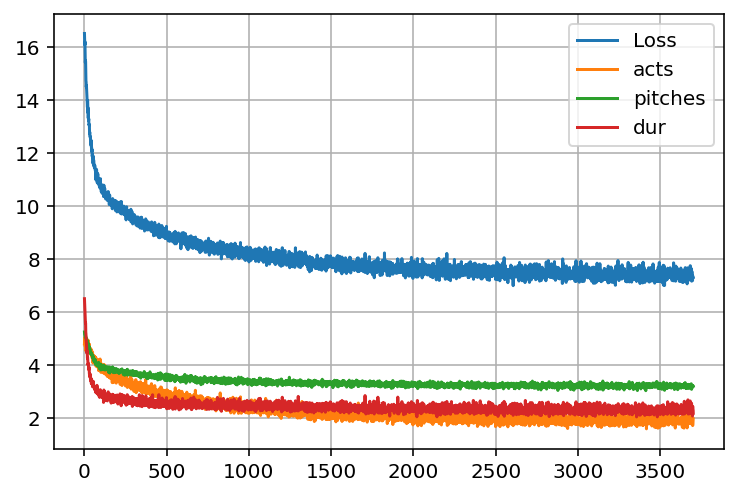

In [150]:
losses = checkpoint['losses']

plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.legend()

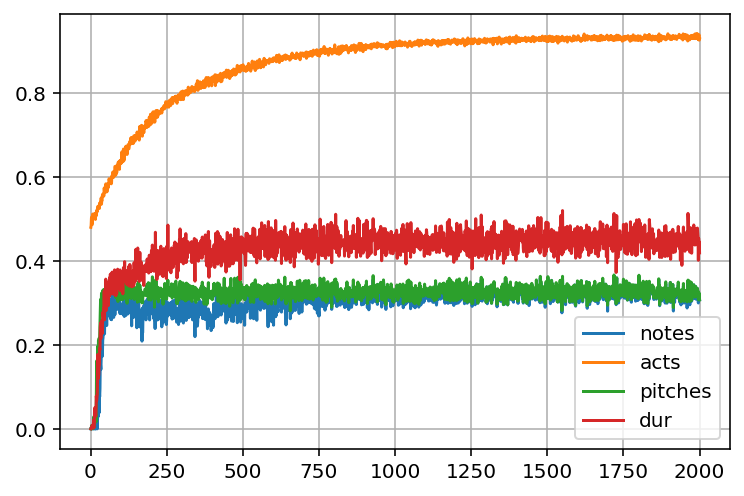

In [130]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.legend()

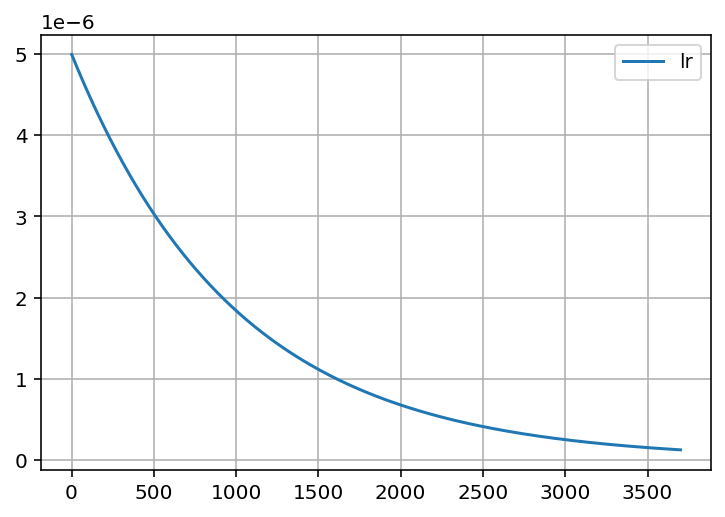

In [151]:
plt.plot(range(1, len(checkpoint['lrs'])+1), checkpoint['lrs'], label='lr')
plt.grid()
plt.legend()

In [152]:
checkpoint['lrs'][-1]

1.2338899884804374e-07

Reconstruct

In [ ]:
dataset[0][0].size()
notes = []
notes.append(muspy.Note(1, 48, 20, 64))
drums = muspy.Track(is_drum=True)
bass = muspy.Track(program=34, notes=notes)
guitar = muspy.Track(program=26, notes=notes)
strings = muspy.Track(program=41)

tracks = [drums, bass, guitar, strings]

meta = muspy.Metadata(title='gay')
music = muspy.Music(tracks=tracks, metadata=meta, resolution=32)
muspy.show_pianoroll(music)

# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape